In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from shap import plots, Explanation
from sklearn.preprocessing import StandardScaler
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics.functional import binary_f1_score
import shap
from tqdm import tqdm
from matplotlib import ticker
import pickle

pd.set_option('display.max_columns', None)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device = 'cpu'

In [4]:
x_features = [    
    "flow_duration", "fwd_pkts_tot", "bwd_pkts_tot",
    "fwd_data_pkts_tot", "bwd_data_pkts_tot", "fwd_pkts_per_sec", "bwd_pkts_per_sec", "flow_pkts_per_sec",
    "down_up_ratio", "fwd_header_size_tot", "fwd_header_size_min", "fwd_header_size_max",
    "bwd_header_size_tot", "bwd_header_size_min", "bwd_header_size_max", "flow_FIN_flag_count",
    "flow_SYN_flag_count", "flow_RST_flag_count", "fwd_PSH_flag_count", "bwd_PSH_flag_count", "flow_ACK_flag_count",
    "fwd_URG_flag_count", "bwd_URG_flag_count", "flow_CWR_flag_count", "flow_ECE_flag_count",
    "fwd_pkts_payload.min", "fwd_pkts_payload.max", "fwd_pkts_payload.tot", "fwd_pkts_payload.avg",
    "fwd_pkts_payload.std", "bwd_pkts_payload.min", "bwd_pkts_payload.max", "bwd_pkts_payload.tot",
    "bwd_pkts_payload.avg", "bwd_pkts_payload.std", "flow_pkts_payload.min", "flow_pkts_payload.max",
    "flow_pkts_payload.tot", "flow_pkts_payload.avg", "flow_pkts_payload.std", "fwd_iat.min",
    "fwd_iat.max", "fwd_iat.tot", "fwd_iat.avg", "fwd_iat.std", "bwd_iat.min", "bwd_iat.max",
    "bwd_iat.tot", "bwd_iat.avg", "bwd_iat.std", "flow_iat.min", "flow_iat.max", "flow_iat.tot",
    "flow_iat.avg", "flow_iat.std", "payload_bytes_per_second", "fwd_subflow_pkts", "bwd_subflow_pkts",
    "fwd_subflow_bytes", "bwd_subflow_bytes", "fwd_bulk_bytes", "bwd_bulk_bytes", "fwd_bulk_packets",
    "bwd_bulk_packets", "fwd_bulk_rate", "bwd_bulk_rate", "active.min", "active.max", "active.tot",
    "active.avg", "active.std", "idle.min", "idle.max", "idle.tot", "idle.avg", "idle.std",
    "fwd_init_window_size", "bwd_init_window_size", "fwd_last_window_size"
]

In [5]:
def stratified_under_sample(group: pd.DataFrame, k: int, random_state: int):
    global category_size
    # shuffle data
    group = group.sample(frac=1, random_state=random_state)
    
    # making a dictionary for checking if all the groups are equally insert into the array
    unique_categories = set(group)
    
    # getting the size of each category per fold
    folded_category = category_size // k
    
    # storing temporary data
    test_res = []
    train_res = []

    for i in range(k):
        test_indexes = []
        train_indexes = []
        
        # for each iteration of the outer loop we need to reset dict
        count_type = {category: 0 for category in unique_categories}
        
        for category in unique_categories:
            # making a window of data to retreive
            if (category == 'Background') | (category == 'Benign'):
                start = (folded_category * 2) * i
                stop = (folded_category * 2) * (i + 1)
            else:
                start = folded_category * i
                stop = folded_category * (i + 1)
            test_indexes.extend(group[group == category].iloc[start:stop].index)
        
        for x in group.index:
            if x not in test_indexes:
                train_indexes.append(x)
                
        # shuffling the data with the same seed in order to have the same result in both the dataset
        np.random.shuffle(test_indexes)
        test_res.append(test_indexes)
        np.random.shuffle(train_indexes)
        train_res.append(train_indexes)
        
    return test_res, train_res

In [6]:
# how need to initialize a nn.relu each time you use it
class MLP(nn.Module):
    def __init__(self, n_features):
        super(MLP, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(n_features, 6), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(6, 3), nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(3, 1), nn.Sigmoid())

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [7]:
def mlp_train(X_train, y_train, verbose, epochs):
    # Initialize the model
    model = MLP(X_train.shape[1]).to(device)

    # Define the loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    if type(X_train) == pd.core.frame.DataFrame:
        X_train = X_train.to_numpy()
    
    # Convert data to PyTorch tensors (assuming X_train and y_train are numpy arrays)
    X_train_tensor = torch.from_numpy(X_train.astype(np.float32)).to(device)
    y_train_tensor = torch.from_numpy(y_train.to_numpy()).to(device)

  

    # Train the model
    epochs = epochs
    batch_size = 200
    
    start_train = time.time()
    for epoch in range(epochs):
        for i in range(0, len(X_train_tensor), batch_size):
            inputs = X_train_tensor[i:i+batch_size]
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

        # Optionally, print the loss at each epoch
        if verbose:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}")

    end_train = time.time()
    print("execution time: ", end_train - start_train)
        
    return model

In [8]:
def cross_validation(X, y, group, verbose, epochs):
    test_kfold, train_kfold = stratified_under_sample(group, 10, 12)
    '''
    if type(X) == pd.core.frame.DataFrame:
        X = X.to_numpy()
    '''
    cvscores = []

    start_cv = time.time()
    for test, train in zip(test_kfold, train_kfold):
        X_train = scaler.transform(X.loc[train])
        X_test = scaler.transform(X.loc[test])
        
        # rimuovere validation a ogni turno
        model = mlp_train(X_train, y[train], False, epochs)
        
        with torch.no_grad():
            model.eval()
            X_test_tensor = torch.from_numpy(X_test.astype(np.float32)).to(device)
            y_predicted = (model(X_test_tensor) >= 0.5).squeeze().cpu()
            
            cvscores.append(metrics.f1_score(y[test], y_predicted))
    end_cv = time.time()    
    
    return np.mean(cvscores), np.std(cvscores), end_cv - start_cv

In [9]:
dtype_dict = {
    'Unnamed: 0': 'uint32',
    'uid': 'str',
    'originh': 'category',
    'originp': 'uint16',
    'responh': 'category',
    'responp': 'uint16',
    'flow_duration': 'float64',
    'fwd_pkts_tot': 'uint64',
    'bwd_pkts_tot': 'uint64',
    'fwd_data_pkts_tot': 'uint64',
    'bwd_data_pkts_tot': 'uint64',
    'fwd_pkts_per_sec': 'float64',
    'bwd_pkts_per_sec': 'float64',
    'flow_pkts_per_sec': 'float64',
    'down_up_ratio': 'float32',
    'fwd_header_size_tot': 'uint64',
    'fwd_header_size_min': 'uint8',
    'fwd_header_size_max': 'uint8',
    'bwd_header_size_tot': 'uint64',
    'bwd_header_size_min': 'uint8',
    'bwd_header_size_max': 'uint8',
    'flow_FIN_flag_count': 'uint64',
    'flow_SYN_flag_count': 'uint64',
    'flow_RST_flag_count': 'uint64',
    'fwd_PSH_flag_count': 'uint64',
    'bwd_PSH_flag_count': 'uint64',
    'flow_ACK_flag_count': 'uint64',
    'fwd_URG_flag_count': 'uint64',
    'bwd_URG_flag_count': 'uint64',
    'flow_CWR_flag_count': 'uint64',
    'flow_ECE_flag_count': 'uint64',
    'fwd_pkts_payload.min': 'uint16',
    'fwd_pkts_payload.max': 'uint16',
    'fwd_pkts_payload.tot': 'float64',
    'fwd_pkts_payload.avg': 'float64',
    'fwd_pkts_payload.std': 'float64',
    'bwd_pkts_payload.min': 'uint16',
    'bwd_pkts_payload.max': 'uint16',
    'bwd_pkts_payload.tot': 'float64',
    'bwd_pkts_payload.avg': 'float64',
    'bwd_pkts_payload.std': 'float64',
    'flow_pkts_payload.min': 'uint16',
    'flow_pkts_payload.max': 'uint16',
    'flow_pkts_payload.tot': 'float64',
    'flow_pkts_payload.avg': 'float64',
    'flow_pkts_payload.std': 'float64',
    'fwd_iat.min': 'float64',
    'fwd_iat.max': 'float64',
    'fwd_iat.tot': 'float64',
    'fwd_iat.avg': 'float64',
    'fwd_iat.std': 'float64',
    'bwd_iat.min': 'float64',
    'bwd_iat.max': 'float64',
    'bwd_iat.tot': 'float64',
    'bwd_iat.avg': 'float64',
    'bwd_iat.std': 'float64',
    'flow_iat.min': 'float64',
    'flow_iat.max': 'float64',
    'flow_iat.tot': 'float64',
    'flow_iat.avg': 'float64',
    'flow_iat.std': 'float64',
    'payload_bytes_per_second': 'float64',
    'fwd_subflow_pkts': 'float64',
    'bwd_subflow_pkts': 'float64',
    'fwd_subflow_bytes': 'float64',
    'bwd_subflow_bytes': 'float64',
    'fwd_bulk_bytes': 'float64',
    'bwd_bulk_bytes': 'float64',
    'fwd_bulk_packets': 'float32',
    'bwd_bulk_packets': 'float32',
    'fwd_bulk_rate': 'float64',
    'bwd_bulk_rate': 'float64',
    'active.min': 'float64',
    'active.max': 'float64',
    'active.tot': 'float64',
    'active.avg': 'float64',
    'active.std': 'float64',
    'idle.min': 'float64',
    'idle.max': 'float64',
    'idle.tot': 'float64',
    'idle.avg': 'float64',
    'idle.std': 'float64',
    'fwd_init_window_size': 'uint16',
    'bwd_init_window_size': 'uint16',
    'fwd_last_window_size': 'uint16',
    'traffic_category': 'category',
    'Label': 'bool'
}

selected_features = [
    "flow_duration", "fwd_pkts_tot", "bwd_pkts_tot",
    "fwd_data_pkts_tot", "bwd_data_pkts_tot", "fwd_pkts_per_sec", "bwd_pkts_per_sec", "flow_pkts_per_sec",
    "down_up_ratio", "fwd_header_size_tot", "fwd_header_size_min", "fwd_header_size_max",
    "bwd_header_size_tot", "bwd_header_size_min", "bwd_header_size_max", "flow_FIN_flag_count",
    "flow_SYN_flag_count", "flow_RST_flag_count", "fwd_PSH_flag_count", "bwd_PSH_flag_count", "flow_ACK_flag_count",
    "fwd_URG_flag_count", "bwd_URG_flag_count", "flow_CWR_flag_count", "flow_ECE_flag_count",
    "fwd_pkts_payload.min", "fwd_pkts_payload.max", "fwd_pkts_payload.tot", "fwd_pkts_payload.avg",
    "fwd_pkts_payload.std", "bwd_pkts_payload.min", "bwd_pkts_payload.max", "bwd_pkts_payload.tot",
    "bwd_pkts_payload.avg", "bwd_pkts_payload.std", "flow_pkts_payload.min", "flow_pkts_payload.max",
    "flow_pkts_payload.tot", "flow_pkts_payload.avg", "flow_pkts_payload.std", "fwd_iat.min",
    "fwd_iat.max", "fwd_iat.tot", "fwd_iat.avg", "fwd_iat.std", "bwd_iat.min", "bwd_iat.max",
    "bwd_iat.tot", "bwd_iat.avg", "bwd_iat.std", "flow_iat.min", "flow_iat.max", "flow_iat.tot",
    "flow_iat.avg", "flow_iat.std", "payload_bytes_per_second", "fwd_subflow_pkts", "bwd_subflow_pkts",
    "fwd_subflow_bytes", "bwd_subflow_bytes", "fwd_bulk_bytes", "bwd_bulk_bytes", "fwd_bulk_packets",
    "bwd_bulk_packets", "fwd_bulk_rate", "bwd_bulk_rate", "active.min", "active.max", "active.tot",
    "active.avg", "active.std", "idle.min", "idle.max", "idle.tot", "idle.avg", "idle.std",
    "fwd_init_window_size", "bwd_init_window_size", "fwd_last_window_size", "traffic_category", "Label"
]

In [10]:
ds = pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_dict, usecols=selected_features)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [11]:
with open('mlp_data/model.pickle', 'rb') as handle:
    model = pickle.load(handle)
    
with open('mlp_data/deep_shap_exp.pickle', 'rb') as handle:
    exp = pickle.load(handle)

In [12]:
category_size = 3279
sampling_weights = {'Background': category_size * 2, 'Benign': category_size * 2, 'XMRIGCC CryptoMiner': category_size, 'Probing': category_size, 'Bruteforce': category_size, 'Bruteforce-XML': category_size}

rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)
X_res, y_res = rus.fit_resample(ds[x_features], ds.traffic_category)

In [13]:
scaler = StandardScaler()
scaler.fit(ds[x_features])

StandardScaler()

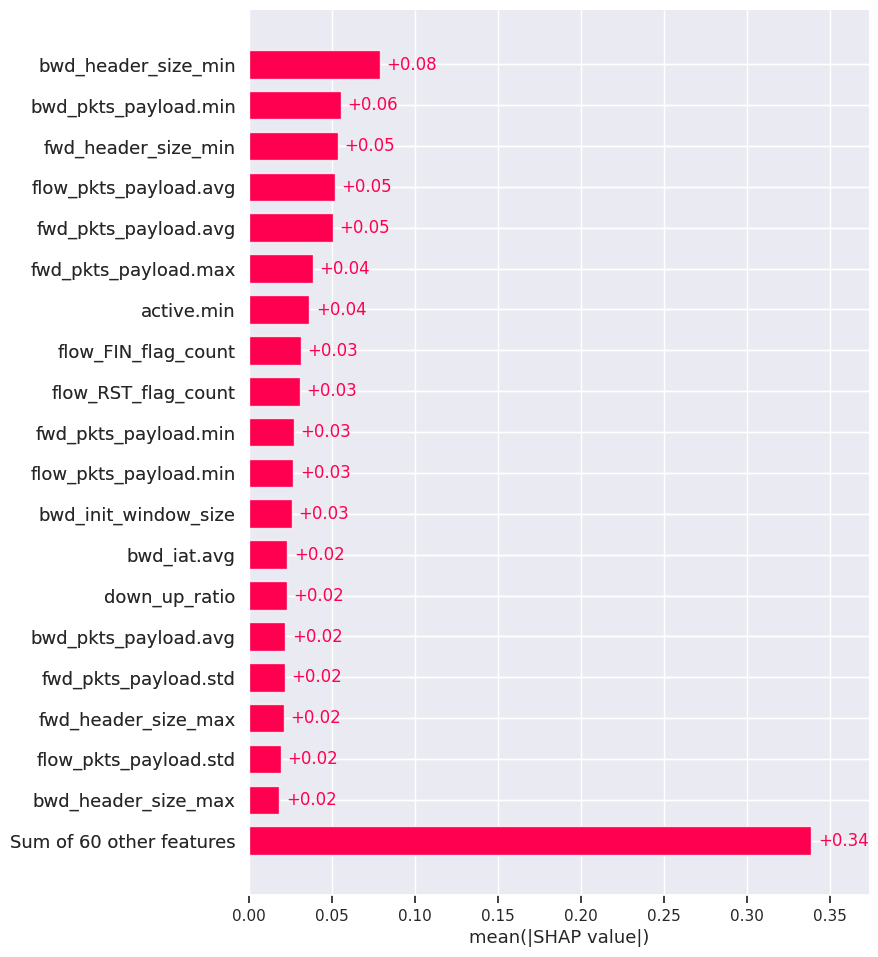

In [25]:
plots.bar(exp, max_display=20, show=False)
# plt.savefig('tree/shap', dpi=1400, format='pdf', pad_inches=10)
plt.show()

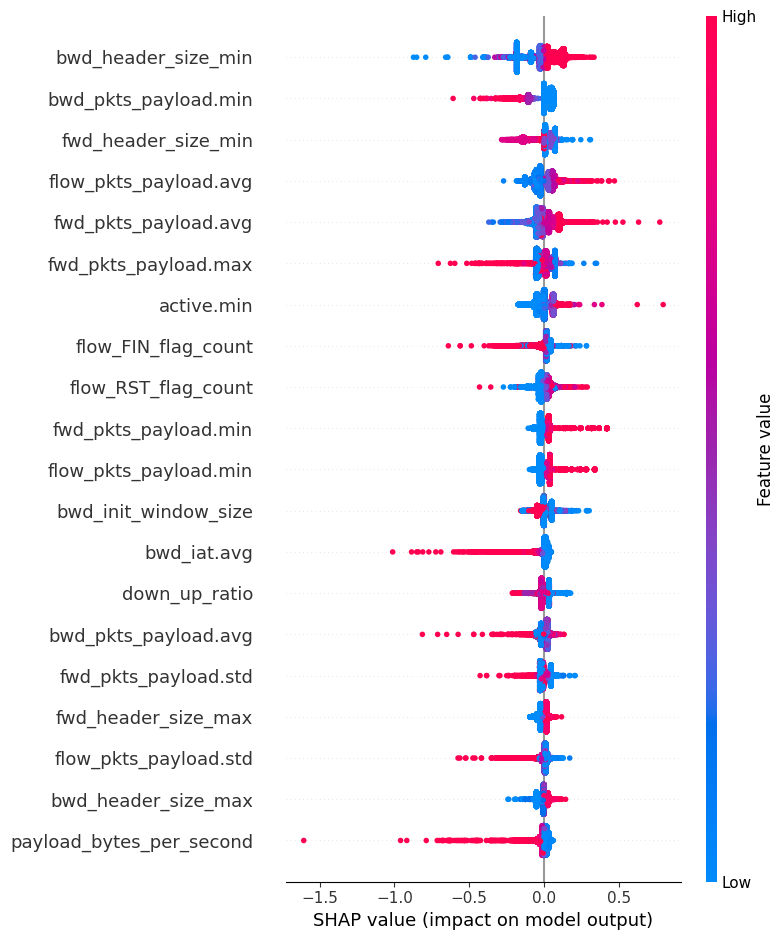

In [14]:
shap.summary_plot(exp, max_display=20)

In [15]:
feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
13,0.079019,bwd_header_size_min
30,0.055526,bwd_pkts_payload.min
10,0.053715,fwd_header_size_min
38,0.051753,flow_pkts_payload.avg
28,0.050679,fwd_pkts_payload.avg
26,0.038525,fwd_pkts_payload.max
66,0.036366,active.min
15,0.031301,flow_FIN_flag_count
17,0.030619,flow_RST_flag_count
25,0.027153,fwd_pkts_payload.min


In [16]:
feature_above_zero = feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [17]:
if False:    
    %%time

    # since I'm using only two tree it make sense to split the job on multiple cores
    # so each forest will take two cores since it have two tree on it and then I will run along side other 6 forest in order to use all the cores
    def get_score(features):
        X = X_res[features]
        y = ds.loc[y_res.index].Label
        cv_mean, cv_std, cv_time = cross_validation(X, y, y_res, 0, 131)
        return cv_mean, cv_std, len(features), cv_time

    def recursive_reduction():
        scores = []
        score_std = []
        n_features = []
        cv_time = []

        global scaler
        scaler.fit(ds[['fwd_iat.tot']])

        # making a warm up run otherwise the first one will be always slower than the others
        # only one features so that it can be as fast as possibile
        get_score(['fwd_iat.tot'])

        scaler.fit(ds[feature_above_zero])
        result = get_score(feature_above_zero)
        scores.append(result[0])
        score_std.append(result[1])
        n_features.append(result[2])    
        cv_time.append(result[3])

        for i in range(1,len(feature_above_zero)):
            print(f"testing with {len(feature_above_zero[:-i])} features")
            scaler.fit(ds[feature_above_zero[:-i]])
            result = get_score(feature_above_zero[:-i])
            scores.append(result[0])
            score_std.append(result[1])
            n_features.append(result[2])
            cv_time.append(result[3])

        return scores, score_std, n_features, cv_time

    result = recursive_reduction()
    feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})
    
    with open('mlp_data/feature_reduction_scores_dl.pickle', 'wb') as handle:
        pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('mlp_data/feature_reduction_scores_dl.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)

execution time:  23.241100788116455
execution time:  22.382463455200195
execution time:  25.807324409484863
execution time:  23.21821165084839
execution time:  19.624114513397217
execution time:  24.78533387184143
execution time:  24.686002016067505
execution time:  24.864227771759033
execution time:  21.221213579177856
execution time:  23.874006271362305
execution time:  22.009422302246094
execution time:  25.723260402679443
execution time:  26.926077365875244
execution time:  26.014734983444214
execution time:  25.209208250045776
execution time:  25.354196071624756
execution time:  25.082455158233643
execution time:  25.845972299575806
execution time:  28.58922815322876
execution time:  27.891730070114136
testing with 77 features
execution time:  27.89479947090149
execution time:  33.709514141082764
execution time:  28.109262228012085
execution time:  15.065305233001709
execution time:  15.705268621444702
execution time:  16.183403730392456
execution time:  14.107132196426392
executi

<Axes: xlabel='n_features', ylabel='cv_time'>

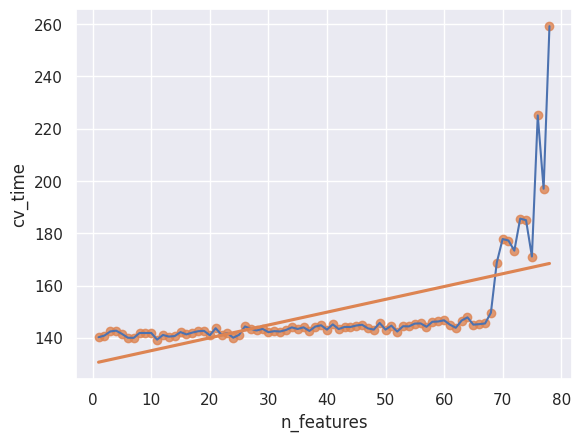

In [19]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="cv_time")
sns.regplot(data=feature_reduction_scores, x="n_features", y="cv_time", ci=None)  # ci=None removes confidence intervals

<Axes: xlabel='n_features', ylabel='F1_score'>

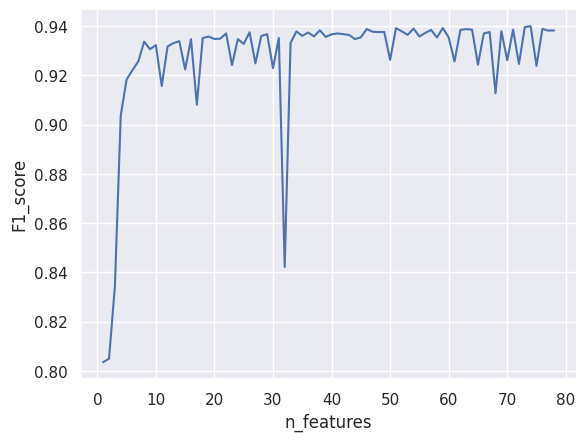

In [20]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="F1_score")

<Axes: xlabel='n_features', ylabel='score_std'>

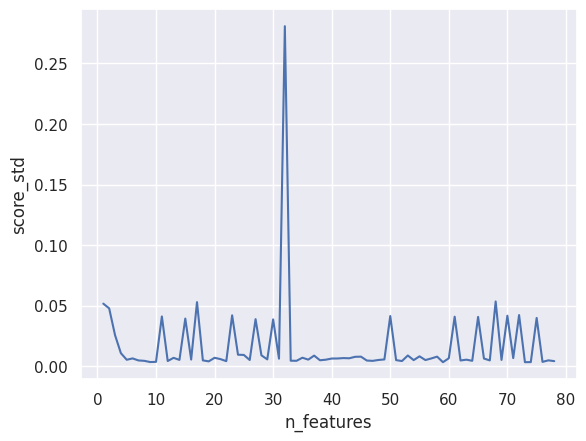

In [21]:
sns.set_theme()
sns.lineplot(data=feature_reduction_scores, x="n_features", y="score_std")

In [22]:
feature_reduction_scores.sort_values('F1_score', ascending=False)

,F1_score,score_std,n_features,cv_time
4,0.939958,0.003390,74,184.980103
5,0.939589,0.003332,73,185.586574
19,0.939206,0.003338,59,146.233027
27,0.939145,0.005032,51,144.639230
24,0.938984,0.005051,54,144.355181
...,...,...,...,...
74,0.903644,0.010782,4,142.717023
46,0.842232,0.280814,32,142.399025
75,0.834318,0.025727,3,142.417032
76,0.805016,0.047778,2,140.842739


In [23]:
if False:    
    # add also training time
    attack_f1 = []
    attack_recall = []
    attack_precision = []
    cv_score_avg = []
    cv_score_std = []
    n_features = []
    attacks = []
    fit_time = []
    pred_time = []

    # warmup boolean, this variable will be used to load in memory the function in order to have reliable time measures
    warmup = True


    def test_zero_day(attack, features, rus, rus_attack):
        print(f"training with {len(features)} features")
        global warmup
        epochs = 99

        X_res, y_res = rus.fit_resample(ds[features], ds.traffic_category)

        X_attack, y_attack = rus_attack.fit_resample(ds[features], ds.traffic_category)
        X_attack = torch.from_numpy(X_attack.to_numpy().astype(np.float32)).to(device)
        y_attack = ds.loc[y_attack.index].Label

        cv_mean, cv_std, cv_time = cross_validation(X_res, ds.loc[y_res.index].Label, y_res, 0, epochs)

        if warmup:
            mlp = mlp_train(X_res, ds.loc[y_res.index].Label, False, epochs)
            with torch.no_grad():
                mlp.eval()
                mlp(X_attack)

        start_fit = time.time()
        mlp = mlp_train(X_res, ds.loc[y_res.index].Label, False, epochs)
        end_fit = time.time()

        with torch.no_grad():
            start_pred = time.time()
            mlp.eval()
            y_predicted = mlp(X_attack)
            end_pred = time.time()
            y_predicted = (y_predicted >= 0.5).squeeze().cpu()

        attack_f1.append(metrics.f1_score(y_attack, y_predicted))
        attack_recall.append(metrics.recall_score(y_attack, y_predicted))
        attack_precision.append(metrics.precision_score(y_attack, y_predicted))
        cv_score_avg.append(cv_mean)
        cv_score_std.append(cv_std)
        n_features.append(len(features))
        attacks.append(attack)
        fit_time.append(end_fit - start_fit)
        pred_time.append(end_pred - start_pred)

        # at the very first iteration we change it to false
        warmup = False

    def recursive_reduction(attack):
        global scaler
        # making a sample for having a 1:1 ration for positive and negative class
        # keep in mind that in the training I will have only three attacks, while for the test only one attack
        sampling_weights = {'Background': 4918, 'Benign': 4918, 'XMRIGCC CryptoMiner': 3279, 'Probing': 3279, 'Bruteforce': 3279, 'Bruteforce-XML': 3279}
        sampling_attack = {'Background': 1638, 'Benign': 1638, 'XMRIGCC CryptoMiner': 0, 'Probing': 0, 'Bruteforce': 0, 'Bruteforce-XML': 0}

        # removing all the attack observations
        sampling_weights[attack] = 0

        # doing the undersampling
        rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)

        # adding the attack to the test dataset with the non attack traffic
        sampling_attack[attack] = 3279

        # making the dataset with only one attack
        rus_attack = RandomUnderSampler(random_state=42, sampling_strategy=sampling_attack)

        scaler.fit(ds[feature_above_zero])
        test_zero_day(attack, feature_above_zero, rus, rus_attack)

        for i in range(1,len(feature_above_zero)):
            scaler.fit(ds[feature_above_zero[:-i]])
            test_zero_day(attack, feature_above_zero[:-i], rus, rus_attack)

    for attack in ['XMRIGCC CryptoMiner','Probing','Bruteforce','Bruteforce-XML']:
        print('traing for ', attack)
        %time recursive_reduction(attack)

    zero_day_feature_reduction_scores = pd.DataFrame({'attack_f1': attack_f1,  'attack_recall': attack_recall, 'attack_precision': attack_precision, 'cv_score_avg': cv_score_avg, 'cv_score_std': cv_score_std, 'n_features': n_features, 'attack_name': attacks, 'fit_time': fit_time, 'pred_time': pred_time})
    
    with open('mlp_data/zero_day_feature_reduction_scores_dl.pickle', 'wb') as handle:
        pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('mlp_data/zero_day_feature_reduction_scores_dl.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)

traing for  XMRIGCC CryptoMiner
training with 78 features
execution time:  9.812068223953247
execution time:  10.279394626617432
execution time:  9.449972867965698
execution time:  9.22813081741333
execution time:  9.186511754989624
execution time:  9.344129800796509
execution time:  10.221956253051758
execution time:  10.200540542602539
execution time:  9.845580577850342
execution time:  9.890907287597656
execution time:  10.541650772094727
execution time:  9.60523509979248


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 77 features
execution time:  8.387905836105347
execution time:  8.312114715576172
execution time:  8.554418802261353
execution time:  8.463443756103516
execution time:  8.897848129272461
execution time:  9.631818532943726
execution time:  8.78975224494934
execution time:  9.071309566497803
execution time:  10.729643106460571
execution time:  9.006346225738525
execution time:  9.640393495559692
training with 76 features
execution time:  8.000848531723022
execution time:  8.25539779663086
execution time:  8.052753448486328
execution time:  8.411715269088745
execution time:  7.985490560531616
execution time:  8.836872577667236
execution time:  8.669578790664673
execution time:  8.76564908027649
execution time:  8.725807189941406
execution time:  8.912678718566895
execution time:  9.154139995574951
training with 75 features
execution time:  10.556938409805298
execution time:  8.480398416519165
execution time:  8.412152528762817
execution time:  8.106992721557617
execution tim

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 63 features
execution time:  8.012135744094849
execution time:  8.050191640853882
execution time:  8.24935507774353
execution time:  8.285934925079346
execution time:  8.118892908096313
execution time:  8.109039545059204
execution time:  8.061220645904541
execution time:  8.546118974685669
execution time:  8.486825942993164
execution time:  8.603092432022095
execution time:  9.07429051399231
training with 62 features
execution time:  7.726535797119141
execution time:  8.145814657211304
execution time:  7.839544773101807
execution time:  7.9945056438446045
execution time:  7.861249208450317
execution time:  8.230423212051392
execution time:  7.905663013458252
execution time:  8.245935201644897
execution time:  8.704411268234253
execution time:  8.802026748657227
execution time:  9.01736307144165
training with 61 features
execution time:  7.872786283493042
execution time:  8.300225019454956
execution time:  8.134826421737671
execution time:  8.897887706756592
execution time

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 60 features
execution time:  7.818387508392334
execution time:  8.303762435913086
execution time:  7.899855375289917
execution time:  8.203748226165771
execution time:  7.886258125305176
execution time:  7.986903667449951
execution time:  8.137362957000732
execution time:  8.577259063720703
execution time:  8.766007423400879
execution time:  8.740256071090698
execution time:  9.335060358047485


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 59 features
execution time:  7.99277663230896
execution time:  7.947960376739502
execution time:  8.077243566513062
execution time:  7.994220972061157
execution time:  8.44745421409607
execution time:  8.089535474777222
execution time:  8.347578287124634
execution time:  8.36951231956482
execution time:  8.791461944580078
execution time:  8.59797716140747
execution time:  9.174048662185669
training with 58 features
execution time:  7.870464324951172
execution time:  7.96880578994751
execution time:  8.10279655456543
execution time:  7.877413034439087
execution time:  7.947327136993408
execution time:  7.778759479522705
execution time:  8.106469631195068
execution time:  8.300076484680176
execution time:  8.861589908599854
execution time:  8.499851703643799
execution time:  9.342937707901001


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 57 features
execution time:  8.05696988105774
execution time:  8.09141492843628
execution time:  8.109058141708374
execution time:  8.059803247451782
execution time:  8.201305866241455
execution time:  8.172333240509033
execution time:  8.196584701538086
execution time:  8.302339553833008
execution time:  8.865662813186646
execution time:  8.753864765167236
execution time:  9.43149995803833
training with 56 features
execution time:  8.073565483093262
execution time:  8.011518478393555
execution time:  8.13871145248413
execution time:  8.161998271942139
execution time:  8.2374746799469
execution time:  7.9685914516448975
execution time:  8.175474882125854
execution time:  8.422884464263916
execution time:  9.039111137390137
execution time:  8.725521802902222
execution time:  9.087101459503174
training with 55 features
execution time:  7.972186088562012
execution time:  7.945570945739746
execution time:  8.129843711853027
execution time:  7.963787078857422
execution time:  

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 54 features
execution time:  7.936940670013428
execution time:  7.8508195877075195
execution time:  8.0274817943573
execution time:  7.966392755508423
execution time:  8.14369511604309
execution time:  7.8503258228302
execution time:  7.982182741165161
execution time:  8.445023775100708
execution time:  8.566567659378052
execution time:  8.875453472137451
execution time:  9.005484104156494
training with 53 features
execution time:  7.666344404220581
execution time:  7.778647184371948
execution time:  8.12800931930542
execution time:  8.204415082931519
execution time:  7.926647186279297
execution time:  8.03519892692566
execution time:  8.03910517692566
execution time:  8.331016540527344
execution time:  8.566152095794678
execution time:  8.712707281112671
execution time:  8.982643365859985
training with 52 features
execution time:  7.816756963729858
execution time:  8.217042684555054
execution time:  7.871452569961548
execution time:  7.978308916091919
execution time:  7.

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 49 features
execution time:  7.971694469451904
execution time:  8.064130783081055
execution time:  7.885566473007202
execution time:  8.099786520004272
execution time:  8.156331777572632
execution time:  8.16963791847229
execution time:  7.9949939250946045
execution time:  8.463302850723267
execution time:  8.462992429733276
execution time:  8.774834871292114
execution time:  9.002705574035645


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 48 features
execution time:  7.79856538772583
execution time:  8.235161781311035
execution time:  8.138235569000244
execution time:  8.034464836120605
execution time:  7.7878334522247314
execution time:  8.043256998062134
execution time:  7.801572322845459
execution time:  8.491040229797363
execution time:  8.384098768234253
execution time:  8.666667461395264
execution time:  9.161296367645264
training with 47 features
execution time:  7.812358617782593
execution time:  8.28440523147583
execution time:  8.088688850402832
execution time:  8.149822473526001
execution time:  8.00147032737732
execution time:  8.192122459411621
execution time:  8.110104084014893
execution time:  8.533430099487305
execution time:  8.665370464324951
execution time:  8.532809495925903
execution time:  9.33042860031128
training with 46 features
execution time:  7.780855178833008
execution time:  8.179808855056763
execution time:  7.8922388553619385
execution time:  8.098037958145142
execution time

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.713637113571167
execution time:  7.970027685165405
execution time:  7.929297208786011
execution time:  8.092806339263916
execution time:  7.956476926803589
execution time:  7.950507164001465
execution time:  7.955420017242432
execution time:  8.509094953536987
execution time:  8.652872562408447
execution time:  8.585453033447266
execution time:  9.143107891082764
training with 44 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.633798360824585
execution time:  7.789327621459961
execution time:  8.211458921432495
execution time:  8.11642050743103
execution time:  8.307517051696777
execution time:  7.933189392089844
execution time:  8.135345697402954
execution time:  8.167370796203613
execution time:  8.702641010284424
execution time:  8.658828258514404
execution time:  9.250614643096924
training with 43 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.188903093338013
execution time:  8.066553831100464
execution time:  8.222298622131348
execution time:  7.809358358383179
execution time:  8.049014806747437
execution time:  7.966789960861206
execution time:  8.134400129318237
execution time:  8.33711576461792
execution time:  8.982648134231567
execution time:  8.45370888710022
execution time:  9.653006792068481
training with 42 features
execution time:  7.98327112197876
execution time:  7.945252418518066
execution time:  8.14201045036316
execution time:  7.7399091720581055
execution time:  8.000699520111084
execution time:  7.729518413543701
execution time:  7.975013732910156
execution time:  8.10669994354248
execution time:  8.623560428619385
execution time:  8.330196857452393
execution time:  9.209062814712524
training with 41 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.940581560134888
execution time:  7.786459445953369
execution time:  8.289120435714722
execution time:  8.082803010940552
execution time:  8.190784454345703
execution time:  7.9977428913116455
execution time:  7.801177978515625
execution time:  8.003257036209106
execution time:  8.634537696838379
execution time:  8.382083892822266
execution time:  9.330677032470703
training with 40 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.9489970207214355
execution time:  7.939199209213257
execution time:  8.056590795516968
execution time:  7.749239921569824
execution time:  8.050085544586182
execution time:  7.701174736022949
execution time:  8.033910512924194
execution time:  8.163863897323608
execution time:  8.644708395004272
execution time:  8.26442265510559
execution time:  8.897698163986206
training with 39 features
execution time:  7.878850221633911
execution time:  7.709601163864136
execution time:  7.933262348175049
execution time:  7.957413911819458
execution time:  8.169975519180298
execution time:  7.711772918701172
execution time:  7.829115867614746
execution time:  8.05026888847351
execution time:  8.407604217529297
execution time:  8.567917346954346
execution time:  9.199493646621704
training with 38 features
execution time:  7.91655158996582
execution time:  7.828882455825806
execution time:  8.115948677062988
execution time:  7.847607612609863
execution time:  7.861556529998779
execu

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.959539175033569
execution time:  7.943546295166016
execution time:  8.048197269439697
execution time:  8.006374597549438
execution time:  8.227712869644165
execution time:  7.824206590652466
execution time:  8.27125883102417
execution time:  8.311844110488892
execution time:  8.500368595123291
execution time:  8.467447519302368
execution time:  9.187382936477661
training with 33 features
execution time:  8.006946086883545
execution time:  7.779887914657593
execution time:  8.04367971420288
execution time:  7.865221261978149
execution time:  8.087887525558472
execution time:  7.8055830001831055
execution time:  7.904477834701538
execution time:  8.251189231872559
execution time:  8.626190185546875
execution time:  8.687685251235962
execution time:  9.529336929321289
training with 32 features
execution time:  8.592202186584473
execution time:  7.912449598312378
execution time:  8.081111669540405
execution time:  7.8051841259002686
execution time:  7.977675676345825
exe

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.826199054718018
execution time:  7.889912843704224
execution time:  7.96551775932312
execution time:  7.804758310317993
execution time:  7.866559982299805
execution time:  7.74075174331665
execution time:  7.982213020324707
execution time:  8.144264698028564
execution time:  8.739891052246094
execution time:  8.32146167755127
execution time:  9.055603265762329
training with 26 features
execution time:  7.935817003250122
execution time:  7.951512813568115
execution time:  8.145699977874756
execution time:  7.853431463241577
execution time:  8.141441345214844
execution time:  7.752262353897095
execution time:  8.190948009490967
execution time:  8.385493755340576
execution time:  8.776361227035522
execution time:  8.614451169967651
execution time:  9.292135000228882
training with 25 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.971740484237671
execution time:  7.7972095012664795
execution time:  8.041082859039307
execution time:  7.928830623626709
execution time:  8.053752183914185
execution time:  7.817422866821289
execution time:  7.954694747924805
execution time:  8.184668779373169
execution time:  8.561646223068237
execution time:  8.439501285552979
execution time:  9.02984094619751
training with 24 features
execution time:  7.907801151275635
execution time:  7.798069715499878
execution time:  7.976240396499634
execution time:  7.775290012359619
execution time:  7.955289840698242
execution time:  8.014768362045288
execution time:  7.906476020812988
execution time:  8.154786586761475
execution time:  8.708126783370972
execution time:  8.463632106781006
execution time:  9.246886491775513
training with 23 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.780771970748901
execution time:  7.9270336627960205
execution time:  7.914543628692627
execution time:  7.743078708648682
execution time:  7.734116315841675
execution time:  7.829327344894409
execution time:  7.869505882263184
execution time:  8.247192859649658
execution time:  8.905357122421265
execution time:  8.59557819366455
execution time:  9.053710699081421
training with 22 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.802645206451416
execution time:  8.206572532653809
execution time:  7.730527877807617
execution time:  8.08985447883606
execution time:  7.885519981384277
execution time:  7.966107606887817
execution time:  7.800402402877808
execution time:  8.386375188827515
execution time:  8.435040950775146
execution time:  8.473033666610718
execution time:  9.006768465042114
training with 21 features
execution time:  7.519958257675171
execution time:  7.801938533782959
execution time:  7.600945472717285
execution time:  7.915240049362183
execution time:  7.696008682250977
execution time:  8.116240501403809
execution time:  7.863996505737305
execution time:  8.499139070510864
execution time:  8.491724491119385
execution time:  8.636801481246948
execution time:  9.006362915039062
training with 20 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.784639358520508
execution time:  8.146124124526978
execution time:  8.014330387115479
execution time:  8.098388195037842
execution time:  7.799714088439941
execution time:  8.019447088241577
execution time:  7.947797536849976
execution time:  8.43424677848816
execution time:  8.525362014770508
execution time:  8.88420820236206
execution time:  9.228065013885498
training with 19 features
execution time:  7.797502279281616
execution time:  7.956937313079834
execution time:  8.015454769134521
execution time:  7.975898504257202
execution time:  7.882511138916016
execution time:  8.083601951599121
execution time:  7.777092695236206
execution time:  8.4885094165802
execution time:  8.401349782943726
execution time:  8.707541704177856
execution time:  9.262517929077148
training with 18 features
execution time:  7.798666477203369
execution time:  8.070042133331299
execution time:  7.947372198104858
execution time:  7.854385852813721
execution time:  7.736215353012085
executi

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.5988450050354
execution time:  8.036941289901733
execution time:  7.754573345184326
execution time:  7.8689963817596436
execution time:  7.748126268386841
execution time:  8.052892923355103
execution time:  7.918760299682617
execution time:  8.431033611297607
execution time:  8.476802825927734
execution time:  8.616486310958862
execution time:  8.87087607383728
training with 15 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.753080368041992
execution time:  7.9571216106414795
execution time:  7.7238242626190186
execution time:  8.118368864059448
execution time:  7.961825370788574
execution time:  7.95551872253418
execution time:  7.789732456207275
execution time:  8.430935144424438
execution time:  8.522017478942871
execution time:  8.745380163192749
execution time:  8.892484188079834
training with 14 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.709574222564697
execution time:  7.8986194133758545
execution time:  7.896667957305908
execution time:  8.029696941375732
execution time:  7.968336820602417
execution time:  7.954894304275513
execution time:  7.711308717727661
execution time:  8.153242349624634
execution time:  8.233869552612305
execution time:  8.489001989364624
execution time:  8.910995483398438
training with 13 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.677955865859985
execution time:  7.787923097610474
execution time:  7.9811930656433105
execution time:  8.073182106018066
execution time:  7.812467575073242
execution time:  8.071593999862671
execution time:  7.890963077545166
execution time:  8.41930627822876
execution time:  8.51870608329773
execution time:  8.816173553466797
execution time:  8.7652907371521
training with 12 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.791899919509888
execution time:  8.07618260383606
execution time:  7.832898855209351
execution time:  8.110077619552612
execution time:  7.727524042129517
execution time:  7.933120965957642
execution time:  7.829116582870483
execution time:  8.324762344360352
execution time:  8.357372999191284
execution time:  8.604835748672485
execution time:  9.072520017623901
training with 11 features
execution time:  7.6901140213012695
execution time:  7.865363597869873
execution time:  7.860635280609131
execution time:  7.820437669754028
execution time:  8.071345090866089
execution time:  7.802300691604614
execution time:  7.991074800491333
execution time:  8.158735990524292
execution time:  8.638196229934692
execution time:  8.65798306465149
execution time:  8.779219627380371
training with 10 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.852118492126465
execution time:  7.77913761138916
execution time:  7.852649927139282
execution time:  7.9048521518707275
execution time:  7.860928297042847
execution time:  7.7563652992248535
execution time:  7.856035947799683
execution time:  8.015578269958496
execution time:  8.278769731521606
execution time:  8.472356796264648
execution time:  9.073146104812622
training with 9 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.10223913192749
execution time:  7.810973405838013
execution time:  7.9101879596710205
execution time:  7.676564693450928
execution time:  7.795645475387573
execution time:  7.878797292709351
execution time:  7.915050745010376
execution time:  8.179327249526978
execution time:  8.407574653625488
execution time:  8.38853931427002
execution time:  8.98973560333252
training with 8 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.9371726512908936
execution time:  7.810577630996704
execution time:  7.939261198043823
execution time:  7.829395771026611
execution time:  7.991960525512695
execution time:  7.440223455429077
execution time:  7.719544410705566
execution time:  7.872049331665039
execution time:  8.364755868911743
execution time:  8.321580410003662
execution time:  8.861044883728027
training with 7 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.939964294433594
execution time:  7.574321746826172
execution time:  7.6512534618377686
execution time:  7.760942459106445
execution time:  7.626314401626587
execution time:  7.93752384185791
execution time:  7.7364630699157715
execution time:  8.223421096801758
execution time:  8.255129337310791
execution time:  8.364649295806885
execution time:  8.86490535736084
training with 6 features
execution time:  7.78958535194397
execution time:  7.963822603225708
execution time:  7.6739771366119385
execution time:  8.010303974151611
execution time:  7.811489105224609
execution time:  7.943025827407837
execution time:  7.70171856880188
execution time:  8.18024730682373
execution time:  8.297636985778809
execution time:  8.658106088638306
execution time:  8.729467868804932
training with 5 features
execution time:  7.935905456542969
execution time:  8.097185134887695
execution time:  7.887825012207031
execution time:  7.988863945007324
execution time:  7.597182512283325
executi

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 75 features
execution time:  8.176571607589722
execution time:  7.911661148071289
execution time:  8.230018377304077
execution time:  7.911893129348755
execution time:  8.118504047393799
execution time:  7.997271537780762
execution time:  7.966118574142456
execution time:  8.223374605178833
execution time:  8.684756994247437
execution time:  8.57464051246643
execution time:  9.097371101379395


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 74 features
execution time:  8.105214357376099
execution time:  7.859638690948486
execution time:  8.20589566230774
execution time:  7.989440441131592
execution time:  7.942451238632202
execution time:  7.924409627914429
execution time:  7.90157151222229
execution time:  8.247856140136719
execution time:  8.653635263442993
execution time:  8.73996639251709
execution time:  9.08762502670288


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 73 features
execution time:  7.766829013824463
execution time:  7.81379246711731
execution time:  7.861726522445679
execution time:  8.295100450515747
execution time:  7.951940059661865
execution time:  8.068179368972778
execution time:  7.911389350891113
execution time:  8.526317119598389
execution time:  8.621561050415039
execution time:  8.726480960845947
execution time:  9.369374513626099


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 72 features
execution time:  8.540953397750854
execution time:  8.16257119178772
execution time:  7.836325645446777
execution time:  8.035037279129028
execution time:  8.001935958862305
execution time:  8.238373041152954
execution time:  7.9662816524505615
execution time:  8.520215034484863
execution time:  8.660982131958008
execution time:  8.594138622283936
execution time:  9.027674436569214


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 71 features
execution time:  8.390541553497314
execution time:  8.102962970733643
execution time:  7.954651594161987
execution time:  8.000168085098267
execution time:  8.091355562210083
execution time:  8.194350957870483
execution time:  8.104569673538208
execution time:  8.623160123825073
execution time:  8.630733966827393
execution time:  8.865909337997437
execution time:  9.24422001838684


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 70 features
execution time:  7.921162843704224
execution time:  8.010318040847778
execution time:  7.916933536529541
execution time:  8.323628425598145
execution time:  7.865557670593262
execution time:  8.106610536575317
execution time:  7.797988653182983
execution time:  8.328965902328491
execution time:  8.405206441879272
execution time:  8.780975103378296
execution time:  8.945279359817505
training with 69 features
execution time:  7.830959320068359
execution time:  8.23414421081543
execution time:  8.126118659973145
execution time:  8.15964388847351
execution time:  7.836394309997559
execution time:  8.151832818984985
execution time:  7.916110515594482
execution time:  8.489071369171143
execution time:  8.523032188415527
execution time:  8.66982388496399
execution time:  9.382582187652588


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 68 features
execution time:  7.840259313583374
execution time:  8.256946086883545
execution time:  7.90711522102356
execution time:  7.963106632232666
execution time:  7.898374319076538
execution time:  8.104340314865112
execution time:  7.997786998748779
execution time:  8.485329151153564
execution time:  8.828881025314331
execution time:  8.673082113265991
execution time:  9.332051992416382


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 67 features
execution time:  7.952434778213501
execution time:  8.174575567245483
execution time:  8.304135799407959
execution time:  7.885597467422485
execution time:  8.161763191223145
execution time:  7.966230154037476
execution time:  8.02521300315857
execution time:  8.198137521743774
execution time:  8.681993007659912
execution time:  8.556578636169434
execution time:  9.297135353088379


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 66 features
execution time:  8.0871262550354
execution time:  7.919074058532715
execution time:  8.105700731277466
execution time:  7.932156085968018
execution time:  8.12635588645935
execution time:  7.815083980560303
execution time:  8.093146562576294
execution time:  8.402867078781128
execution time:  8.833781242370605
execution time:  8.412099838256836
execution time:  9.272177696228027
training with 65 features
execution time:  8.588988065719604
execution time:  7.869394540786743
execution time:  8.17551040649414
execution time:  7.821000337600708
execution time:  7.997850656509399
execution time:  8.08639407157898
execution time:  7.970662832260132
execution time:  8.176687955856323
execution time:  8.536913871765137
execution time:  8.75050687789917
execution time:  9.105117797851562
training with 64 features
execution time:  7.999234199523926
execution time:  7.984862565994263
execution time:  8.26487112045288
execution time:  8.212855577468872
execution time:  8.

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 62 features
execution time:  8.077863693237305
execution time:  8.046745538711548
execution time:  8.181969404220581
execution time:  7.963355779647827
execution time:  8.056311130523682
execution time:  7.914718389511108
execution time:  8.08226466178894
execution time:  8.484111070632935
execution time:  8.69749641418457
execution time:  8.829553127288818
execution time:  9.108404636383057
training with 61 features
execution time:  8.19475769996643
execution time:  8.234649419784546
execution time:  8.094314098358154
execution time:  8.21379804611206
execution time:  8.192807674407959
execution time:  8.12520146369934
execution time:  8.032482147216797
execution time:  8.83447003364563
execution time:  8.726156949996948
execution time:  8.790943622589111
execution time:  9.323797225952148
training with 60 features
execution time:  7.8940370082855225
execution time:  7.90505838394165
execution time:  8.002926588058472
execution time:  8.073781251907349
execution time:  7

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 59 features
execution time:  8.057638883590698
execution time:  8.13264775276184
execution time:  8.125970363616943
execution time:  8.071238279342651
execution time:  7.993409633636475
execution time:  8.030155420303345
execution time:  8.106687068939209
execution time:  8.452101469039917
execution time:  8.737398862838745
execution time:  8.98102879524231
execution time:  9.173207521438599
training with 58 features
execution time:  8.150630950927734
execution time:  8.231881856918335
execution time:  7.8383629322052
execution time:  8.230449438095093
execution time:  7.880454063415527
execution time:  8.045571088790894
execution time:  7.9281182289123535
execution time:  8.497932195663452
execution time:  8.63894009590149
execution time:  8.923412561416626
execution time:  9.212024927139282


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 57 features
execution time:  7.875290393829346
execution time:  7.970048666000366
execution time:  7.8842103481292725
execution time:  7.982146739959717
execution time:  7.772035360336304
execution time:  8.087575674057007
execution time:  7.922878980636597
execution time:  8.377380847930908
execution time:  8.567468166351318
execution time:  8.878309965133667
execution time:  9.375896692276001


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 56 features
execution time:  8.303656339645386
execution time:  8.203726291656494
execution time:  8.04767107963562
execution time:  8.005794763565063
execution time:  8.241597890853882
execution time:  7.98630428314209
execution time:  8.228273391723633
execution time:  8.504446506500244
execution time:  8.660992860794067
execution time:  8.551108121871948
execution time:  8.957557201385498


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 55 features
execution time:  7.835198640823364
execution time:  7.758796215057373
execution time:  8.017928123474121
execution time:  7.799091100692749
execution time:  8.111382007598877
execution time:  7.828096866607666
execution time:  8.190163850784302
execution time:  8.179641962051392
execution time:  8.694354772567749
execution time:  8.607335805892944
execution time:  9.149635553359985
training with 54 features
execution time:  7.9571919441223145
execution time:  7.882947206497192
execution time:  8.133581161499023
execution time:  7.868122100830078
execution time:  8.323040246963501
execution time:  7.986356019973755
execution time:  8.072076797485352
execution time:  8.615065336227417
execution time:  8.969010829925537
execution time:  8.597296237945557
execution time:  9.457545042037964


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 53 features
execution time:  8.035858154296875
execution time:  7.702635765075684
execution time:  7.999420642852783
execution time:  7.897148609161377
execution time:  8.001577854156494
execution time:  7.722913026809692
execution time:  7.9539079666137695
execution time:  8.013991355895996
execution time:  8.638566732406616
execution time:  8.444157600402832
execution time:  9.286412000656128


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 52 features
execution time:  7.948022365570068
execution time:  7.826183557510376
execution time:  8.294373989105225
execution time:  7.784329175949097
execution time:  8.07050347328186
execution time:  7.90807843208313
execution time:  8.211576461791992
execution time:  8.2563316822052
execution time:  8.55616307258606
execution time:  8.377983093261719
execution time:  9.397616624832153
training with 51 features
execution time:  7.922893762588501
execution time:  7.914825677871704
execution time:  7.9378111362457275
execution time:  7.899802207946777
execution time:  7.834028244018555
execution time:  7.742672681808472
execution time:  8.019505500793457
execution time:  8.474194288253784
execution time:  8.742029428482056
execution time:  8.509947776794434
execution time:  9.078859329223633


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 50 features
execution time:  8.126278638839722
execution time:  7.973302125930786
execution time:  7.971792221069336
execution time:  7.824018478393555
execution time:  8.034248352050781
execution time:  7.782394170761108
execution time:  7.936065912246704
execution time:  8.147702693939209
execution time:  8.69227409362793
execution time:  8.363479137420654
execution time:  9.325383424758911
training with 49 features
execution time:  8.050898313522339
execution time:  7.874659299850464
execution time:  8.116474628448486
execution time:  7.989181756973267
execution time:  8.108919382095337
execution time:  7.907831430435181
execution time:  7.973996639251709
execution time:  8.223271369934082
execution time:  8.738481521606445
execution time:  8.459285020828247
execution time:  9.02909803390503


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 48 features
execution time:  7.924004316329956
execution time:  7.761188745498657
execution time:  7.853418588638306
execution time:  7.8996741771698
execution time:  8.029003620147705
execution time:  7.871877193450928
execution time:  8.19884443283081
execution time:  8.082520484924316
execution time:  8.615606784820557
execution time:  8.366819858551025
execution time:  9.218057632446289
training with 47 features
execution time:  7.932289361953735
execution time:  7.797400951385498
execution time:  7.9374940395355225
execution time:  7.85553240776062
execution time:  8.054115533828735
execution time:  7.809045791625977
execution time:  8.120623350143433
execution time:  8.366204977035522
execution time:  8.790570974349976
execution time:  8.69858193397522
execution time:  9.311728715896606
training with 46 features
execution time:  8.168101787567139
execution time:  7.779844045639038
execution time:  8.044800043106079
execution time:  7.845557689666748
execution time: 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.121415615081787
execution time:  7.738040924072266
execution time:  8.129131555557251
execution time:  7.81831169128418
execution time:  8.047427415847778
execution time:  7.793866157531738
execution time:  8.137603044509888
execution time:  8.3881995677948
execution time:  8.665995836257935
execution time:  8.464919328689575
execution time:  9.194364786148071
training with 44 features
execution time:  7.972851276397705
execution time:  7.71523642539978
execution time:  8.065785884857178
execution time:  7.654081583023071
execution time:  7.783184289932251
execution time:  7.810588836669922
execution time:  7.910194635391235
execution time:  8.053200483322144
execution time:  8.827845811843872
execution time:  8.634483098983765
execution time:  9.247077465057373
training with 43 features
execution time:  8.021948099136353
execution time:  7.697371959686279
execution time:  8.028140544891357
execution time:  8.01710295677185
execution time:  7.863393783569336
executio

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.927399158477783
execution time:  7.812052249908447
execution time:  8.231671810150146
execution time:  7.707037687301636
execution time:  7.984907865524292
execution time:  7.712199687957764
execution time:  8.123841285705566
execution time:  8.196095943450928
execution time:  8.610182523727417
execution time:  8.42188310623169
execution time:  9.18095850944519
training with 41 features
execution time:  8.022227048873901
execution time:  7.993425369262695
execution time:  8.18048620223999
execution time:  7.873617649078369
execution time:  8.029036283493042
execution time:  7.943657636642456
execution time:  8.200347661972046
execution time:  8.25568962097168
execution time:  8.68507170677185
execution time:  8.705227375030518
execution time:  9.228248357772827
training with 40 features
execution time:  7.949040651321411
execution time:  7.897938013076782
execution time:  8.059374570846558
execution time:  7.851523399353027
execution time:  8.121964931488037
executio

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.8728859424591064
execution time:  7.776326656341553
execution time:  7.851222276687622
execution time:  7.9565160274505615
execution time:  8.180976629257202
execution time:  7.9981725215911865
execution time:  7.773544073104858
execution time:  8.122059345245361
execution time:  8.522976160049438
execution time:  8.468826055526733
execution time:  9.031479358673096
training with 37 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.687427759170532
execution time:  7.790783643722534
execution time:  7.905761241912842
execution time:  7.962299346923828
execution time:  7.771462678909302
execution time:  7.798189640045166
execution time:  7.689077138900757
execution time:  8.301370620727539
execution time:  8.392905473709106
execution time:  8.467143058776855
execution time:  8.875032901763916
training with 36 features
execution time:  7.913620948791504
execution time:  7.794503927230835
execution time:  7.7426557540893555
execution time:  8.039916038513184
execution time:  7.776022911071777
execution time:  7.863637447357178
execution time:  7.7965309619903564
execution time:  8.174222707748413
execution time:  8.316404819488525
execution time:  8.436961650848389
execution time:  8.83046579360962
training with 35 features
execution time:  7.776771783828735
execution time:  7.896389961242676
execution time:  7.994002342224121
execution time:  8.08073616027832
execution time:  7.853887319564819
exe

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.815053939819336
execution time:  7.880336046218872
execution time:  7.8365278244018555
execution time:  8.166574239730835
execution time:  7.777142286300659
execution time:  7.969553232192993
execution time:  7.643614768981934
execution time:  8.385076522827148
execution time:  8.805609703063965
execution time:  8.740668296813965
execution time:  9.055333852767944
training with 30 features
execution time:  7.813601732254028
execution time:  8.035428047180176
execution time:  7.827167987823486
execution time:  8.208531856536865
execution time:  7.80959939956665
execution time:  7.997998476028442
execution time:  8.006709337234497
execution time:  8.463058471679688
execution time:  8.617244005203247
execution time:  8.717291355133057
execution time:  9.061520338058472
training with 29 features
execution time:  7.940783977508545
execution time:  7.8660056591033936
execution time:  7.82522988319397
execution time:  7.967782735824585
execution time:  7.704061985015869
exe

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.003172874450684
execution time:  7.757890701293945
execution time:  7.982757568359375
execution time:  7.771114110946655
execution time:  8.156298160552979
execution time:  7.81638503074646
execution time:  7.987807750701904
execution time:  8.248466730117798
execution time:  8.480406999588013
execution time:  8.344406366348267
execution time:  9.223033428192139
training with 24 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.012156009674072
execution time:  7.709681034088135
execution time:  7.9927027225494385
execution time:  7.751825332641602
execution time:  7.865420818328857
execution time:  7.595529556274414
execution time:  7.88175630569458
execution time:  8.115186214447021
execution time:  8.696696043014526
execution time:  8.30486273765564
execution time:  9.157661437988281
training with 23 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.913488149642944
execution time:  7.878995656967163
execution time:  8.21687626838684
execution time:  7.855247259140015
execution time:  7.901890754699707
execution time:  7.753932237625122
execution time:  8.142349481582642
execution time:  8.15940546989441
execution time:  8.594346523284912
execution time:  8.418968677520752
execution time:  9.270481586456299
training with 22 features
execution time:  7.9125425815582275
execution time:  7.782278299331665
execution time:  7.878155946731567
execution time:  7.781163454055786
execution time:  7.761688470840454
execution time:  7.716997861862183
execution time:  7.96477746963501
execution time:  8.08208179473877
execution time:  8.64060926437378
execution time:  8.432207107543945
execution time:  8.932321786880493
training with 21 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.995466947555542
execution time:  7.717695951461792
execution time:  7.922018766403198
execution time:  7.666633129119873
execution time:  7.952260255813599
execution time:  7.708865165710449
execution time:  7.958515644073486
execution time:  8.071967124938965
execution time:  8.580675840377808
execution time:  8.436631679534912
execution time:  9.110394716262817
training with 20 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.9764909744262695
execution time:  7.819318771362305
execution time:  8.156749963760376
execution time:  7.805863857269287
execution time:  8.099666118621826
execution time:  7.738072633743286
execution time:  7.74600625038147
execution time:  8.169224977493286
execution time:  8.61890697479248
execution time:  8.326904058456421
execution time:  9.042787551879883
training with 19 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.742555618286133
execution time:  7.9605395793914795
execution time:  7.70602011680603
execution time:  8.024160623550415
execution time:  7.742891073226929
execution time:  7.892444849014282
execution time:  7.866358041763306
execution time:  8.164538383483887
execution time:  8.395424842834473
execution time:  8.494848489761353
execution time:  8.81888723373413
training with 18 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.66705846786499
execution time:  7.980927467346191
execution time:  7.610595941543579
execution time:  7.8081817626953125
execution time:  7.735422372817993
execution time:  8.022876262664795
execution time:  7.745057106018066
execution time:  8.272557973861694
execution time:  8.355067253112793
execution time:  8.43787932395935
execution time:  8.794170141220093
training with 17 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.936143398284912
execution time:  7.9500885009765625
execution time:  7.851666450500488
execution time:  8.090223789215088
execution time:  8.01723861694336
execution time:  7.951644420623779
execution time:  7.914743661880493
execution time:  8.329651117324829
execution time:  8.512266635894775
execution time:  8.647018671035767
execution time:  8.922441959381104
training with 16 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.684394836425781
execution time:  7.8082685470581055
execution time:  7.712106704711914
execution time:  7.900742292404175
execution time:  7.5943074226379395
execution time:  8.0801682472229
execution time:  7.696839094161987
execution time:  8.272050857543945
execution time:  8.295991897583008
execution time:  8.639047384262085
execution time:  8.986936569213867
training with 15 features
execution time:  7.703460454940796
execution time:  7.958316802978516
execution time:  7.774926662445068
execution time:  7.821221351623535
execution time:  7.755860328674316
execution time:  7.703764915466309
execution time:  7.739184141159058
execution time:  8.196191787719727
execution time:  8.243308782577515
execution time:  8.48159384727478
execution time:  8.8340322971344
training with 14 features
execution time:  7.957148790359497
execution time:  7.950013875961304
execution time:  7.760305404663086
execution time:  7.721405029296875
execution time:  7.953455209732056
execut

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.773952007293701
execution time:  7.64489221572876
execution time:  7.823339462280273
execution time:  7.872483730316162
execution time:  7.981395244598389
execution time:  7.7932448387146
execution time:  7.905307769775391
execution time:  8.268563270568848
execution time:  8.570361375808716
execution time:  8.313918828964233
execution time:  8.799428462982178
training with 12 features
execution time:  7.698230743408203
execution time:  7.733227491378784
execution time:  7.960906028747559
execution time:  7.886247396469116
execution time:  7.645151138305664
execution time:  7.656235933303833
execution time:  7.884192228317261
execution time:  7.991568088531494
execution time:  8.641188859939575
execution time:  8.323087453842163
execution time:  8.988667964935303
training with 11 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.780550241470337
execution time:  7.723394870758057
execution time:  7.733229398727417
execution time:  7.645671129226685
execution time:  7.963773488998413
execution time:  7.711190700531006
execution time:  7.951576232910156
execution time:  8.103705883026123
execution time:  8.445342302322388
execution time:  8.245777368545532
execution time:  8.887647867202759
training with 10 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.796978712081909
execution time:  7.667732238769531
execution time:  7.630730152130127
execution time:  7.920267581939697
execution time:  7.646706819534302
execution time:  7.901435375213623
execution time:  7.751617193222046
execution time:  8.164870500564575
execution time:  8.229210615158081
execution time:  8.449519395828247
execution time:  9.163156032562256
training with 9 features
execution time:  7.790587425231934
execution time:  7.897634506225586
execution time:  7.682731628417969
execution time:  7.9495320320129395
execution time:  7.676971912384033
execution time:  7.783967733383179
execution time:  7.833139896392822
execution time:  8.324575662612915
execution time:  8.457647800445557
execution time:  8.572715759277344
execution time:  8.813584566116333
training with 8 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.64730429649353
execution time:  7.943640470504761
execution time:  7.734933137893677
execution time:  7.949610710144043
execution time:  7.70106840133667
execution time:  7.875864267349243
execution time:  7.633679389953613
execution time:  8.106983423233032
execution time:  8.236543893814087
execution time:  8.485437393188477
execution time:  8.763014316558838
training with 7 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.499186038970947
execution time:  8.138235569000244
execution time:  7.721286773681641
execution time:  7.993358850479126
execution time:  7.659658908843994
execution time:  7.898345470428467
execution time:  7.731524467468262
execution time:  8.36299991607666
execution time:  8.46276068687439
execution time:  8.375815868377686
execution time:  8.861442565917969
training with 6 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.713305950164795
execution time:  7.894461393356323
execution time:  7.854115962982178
execution time:  7.695090055465698
execution time:  7.730986595153809
execution time:  7.59097695350647
execution time:  7.747019052505493
execution time:  8.117703676223755
execution time:  8.664866924285889
execution time:  8.82714295387268
execution time:  8.982709884643555
training with 5 features
execution time:  7.904702186584473
execution time:  7.7247092723846436
execution time:  8.157171249389648
execution time:  7.7436463832855225
execution time:  8.109305143356323
execution time:  7.836845874786377
execution time:  7.768121957778931
execution time:  8.0933198928833
execution time:  8.616756677627563
execution time:  8.469066381454468
execution time:  8.830365896224976
training with 4 features
execution time:  7.9091668128967285
execution time:  7.803750038146973
execution time:  7.891235828399658
execution time:  7.572078227996826
execution time:  7.815881013870239
execut

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 75 features
execution time:  7.947843551635742
execution time:  8.124196767807007
execution time:  7.949328422546387
execution time:  8.020138263702393
execution time:  7.94726300239563
execution time:  8.161537647247314
execution time:  7.971237659454346
execution time:  8.477542877197266
execution time:  8.906694173812866
execution time:  8.664266109466553
execution time:  9.214553833007812


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 74 features
execution time:  7.986339330673218
execution time:  7.83579421043396
execution time:  8.176559686660767
execution time:  7.971681594848633
execution time:  8.078797817230225
execution time:  7.801989793777466
execution time:  8.218446016311646
execution time:  8.46921157836914
execution time:  8.839548110961914
execution time:  8.556986808776855
execution time:  9.237295627593994
training with 73 features
execution time:  8.191322565078735
execution time:  7.937283992767334
execution time:  7.982405424118042
execution time:  7.803480863571167
execution time:  7.968030691146851
execution time:  7.939533710479736
execution time:  8.115678787231445
execution time:  8.19683313369751
execution time:  8.802566528320312
execution time:  8.543307542800903
execution time:  9.097394227981567
training with 72 features
execution time:  7.912314176559448
execution time:  7.818159580230713
execution time:  8.066434860229492
execution time:  7.8324809074401855
execution time

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 70 features
execution time:  7.944170236587524
execution time:  7.772340536117554
execution time:  8.016698360443115
execution time:  8.021701335906982
execution time:  7.836655855178833
execution time:  7.899895429611206
execution time:  8.301876068115234
execution time:  8.123445510864258
execution time:  8.709259510040283
execution time:  8.45423150062561
execution time:  9.062089443206787


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 69 features
execution time:  7.962665319442749
execution time:  7.838399648666382
execution time:  8.167450904846191
execution time:  7.909836053848267
execution time:  7.962680339813232
execution time:  7.905174970626831
execution time:  8.173632621765137
execution time:  8.235071420669556
execution time:  8.766319751739502
execution time:  8.489994764328003
execution time:  9.07438039779663
training with 68 features
execution time:  8.031681299209595
execution time:  7.9480671882629395
execution time:  8.135056257247925
execution time:  7.809801340103149
execution time:  8.073881387710571
execution time:  7.948622226715088
execution time:  8.115739345550537
execution time:  8.294898271560669
execution time:  8.778390169143677
execution time:  8.639132261276245
execution time:  9.216416358947754
training with 67 features
execution time:  8.106963396072388
execution time:  7.866778612136841
execution time:  8.014889240264893
execution time:  7.877671241760254
execution ti

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 66 features
execution time:  8.030552864074707
execution time:  7.94371223449707
execution time:  8.172502756118774
execution time:  8.014526605606079
execution time:  7.970000267028809
execution time:  7.7698047161102295
execution time:  8.133733034133911
execution time:  8.323656558990479
execution time:  8.74128794670105
execution time:  8.376551389694214
execution time:  9.127708435058594


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 65 features
execution time:  8.081287384033203
execution time:  8.001989364624023
execution time:  8.11721420288086
execution time:  8.247758388519287
execution time:  8.155824661254883
execution time:  7.906947612762451
execution time:  8.087302446365356
execution time:  8.134103775024414
execution time:  8.536296844482422
execution time:  8.451815366744995
execution time:  9.225025415420532


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 64 features
execution time:  8.24026083946228
execution time:  7.973367214202881
execution time:  8.234493017196655
execution time:  7.962641000747681
execution time:  8.025217533111572
execution time:  7.862874507904053
execution time:  8.0643310546875
execution time:  8.36280083656311
execution time:  8.765863180160522
execution time:  8.929973125457764
execution time:  9.163785457611084


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 63 features
execution time:  8.190948247909546
execution time:  8.011241674423218
execution time:  8.121412515640259
execution time:  7.970429182052612
execution time:  8.277828931808472
execution time:  8.267487287521362
execution time:  8.06873631477356
execution time:  8.366700887680054
execution time:  8.678650617599487
execution time:  8.81728196144104
execution time:  8.952510833740234


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 62 features
execution time:  7.886667728424072
execution time:  8.130362510681152
execution time:  8.0461745262146
execution time:  8.348928689956665
execution time:  8.220108270645142
execution time:  8.31713318824768
execution time:  8.068870782852173
execution time:  8.476454973220825
execution time:  8.591537475585938
execution time:  8.86370301246643
execution time:  9.327146291732788
training with 61 features
execution time:  7.920790433883667
execution time:  8.028005123138428
execution time:  7.952392816543579
execution time:  8.077547550201416
execution time:  8.139650344848633
execution time:  8.314830303192139
execution time:  8.08606767654419
execution time:  8.609473943710327
execution time:  8.880067825317383
execution time:  8.868667125701904
execution time:  9.24116587638855


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 60 features
execution time:  7.792678356170654
execution time:  7.95065975189209
execution time:  7.806018352508545
execution time:  8.092742681503296
execution time:  7.8522562980651855
execution time:  7.990771770477295
execution time:  7.834396123886108
execution time:  8.722318172454834
execution time:  8.385453939437866
execution time:  8.756246566772461
execution time:  9.298672199249268
training with 59 features
execution time:  8.080536127090454
execution time:  8.107659339904785
execution time:  7.929400205612183
execution time:  8.18773627281189
execution time:  8.072203636169434
execution time:  8.206597328186035
execution time:  8.193150997161865
execution time:  8.5461266040802
execution time:  8.962543964385986
execution time:  8.53813886642456
execution time:  9.508719444274902


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 58 features
execution time:  8.162170171737671
execution time:  7.9629740715026855
execution time:  8.107299566268921
execution time:  8.160346746444702
execution time:  8.19874382019043
execution time:  7.965480327606201
execution time:  8.161173582077026
execution time:  8.351832866668701
execution time:  9.027082443237305
execution time:  8.424599647521973
execution time:  9.196980476379395
training with 57 features
execution time:  7.972393035888672
execution time:  7.864760637283325
execution time:  7.920335292816162
execution time:  8.058716058731079
execution time:  8.143850088119507
execution time:  8.12221622467041
execution time:  8.120827913284302
execution time:  8.260969638824463
execution time:  8.881810188293457
execution time:  8.589959144592285
execution time:  9.170918464660645


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 56 features
execution time:  8.1150643825531
execution time:  7.959423542022705
execution time:  8.122213363647461
execution time:  7.894599676132202
execution time:  8.17179822921753
execution time:  7.918282747268677
execution time:  8.105220079421997
execution time:  8.450994491577148
execution time:  8.858661890029907
execution time:  8.59896731376648
execution time:  9.224174976348877


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 55 features
execution time:  8.018102407455444
execution time:  7.873189687728882
execution time:  8.003974914550781
execution time:  7.895224332809448
execution time:  8.17142653465271
execution time:  7.824325799942017
execution time:  8.12325930595398
execution time:  8.415539979934692
execution time:  8.876878499984741
execution time:  8.68380331993103
execution time:  9.426430702209473


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 54 features
execution time:  8.39746642112732
execution time:  7.946508407592773
execution time:  8.069988012313843
execution time:  8.073573350906372
execution time:  8.315943479537964
execution time:  8.019286394119263
execution time:  8.038141965866089
execution time:  8.258411884307861
execution time:  8.893945693969727
execution time:  8.879802465438843
execution time:  9.089555025100708


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 53 features
execution time:  7.959595680236816
execution time:  7.885977029800415
execution time:  8.142395496368408
execution time:  7.924840927124023
execution time:  8.129566431045532
execution time:  8.092901229858398
execution time:  7.87138819694519
execution time:  8.328554153442383
execution time:  8.452455759048462
execution time:  8.41138768196106
execution time:  8.998393535614014


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 52 features
execution time:  7.866574048995972
execution time:  7.86564826965332
execution time:  7.9840006828308105
execution time:  7.730298757553101
execution time:  8.167667627334595
execution time:  7.971394300460815
execution time:  7.94306492805481
execution time:  8.547607421875
execution time:  8.551573038101196
execution time:  8.682614803314209
execution time:  9.218628168106079
training with 51 features
execution time:  8.113770008087158
execution time:  8.120269060134888
execution time:  8.121117353439331
execution time:  8.321200847625732
execution time:  8.048218488693237
execution time:  8.174757719039917
execution time:  8.034209251403809
execution time:  8.271315574645996
execution time:  8.637701988220215
execution time:  8.77978229522705
execution time:  9.047424554824829


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 50 features
execution time:  7.698409557342529
execution time:  8.094265460968018
execution time:  7.783323287963867
execution time:  8.033947944641113
execution time:  7.875120401382446
execution time:  8.154515981674194
execution time:  7.866891145706177
execution time:  8.497150659561157
execution time:  8.70589804649353
execution time:  8.595840215682983
execution time:  8.901773452758789


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 49 features
execution time:  7.7784810066223145
execution time:  7.883277893066406
execution time:  7.802151441574097
execution time:  7.8647449016571045
execution time:  7.795748949050903
execution time:  8.092868089675903
execution time:  7.751530408859253
execution time:  8.553625345230103
execution time:  8.47681975364685
execution time:  8.829184293746948
execution time:  9.313168287277222


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 48 features
execution time:  7.742541551589966
execution time:  7.728335857391357
execution time:  7.955665826797485
execution time:  8.112195014953613
execution time:  7.86697244644165
execution time:  8.14278244972229
execution time:  8.095986604690552
execution time:  8.428824424743652
execution time:  8.48080849647522
execution time:  8.702807903289795
execution time:  9.055511236190796
training with 47 features
execution time:  7.929928779602051
execution time:  8.143341302871704
execution time:  7.803235292434692
execution time:  8.098505973815918
execution time:  7.793476819992065
execution time:  8.157548427581787
execution time:  7.753926515579224
execution time:  8.292750597000122
execution time:  8.422158479690552
execution time:  8.66715407371521
execution time:  9.05132508277893
training with 46 features
execution time:  7.8583152294158936
execution time:  8.0476655960083
execution time:  7.949866533279419
execution time:  8.00296926498413
execution time:  7.

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.878756046295166
execution time:  8.280500173568726
execution time:  7.847646474838257
execution time:  8.0514235496521
execution time:  7.787764310836792
execution time:  7.940861463546753
execution time:  7.752945184707642
execution time:  8.627573251724243
execution time:  8.343273639678955
execution time:  8.692069053649902
execution time:  8.753669500350952
training with 44 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.69201397895813
execution time:  7.880267143249512
execution time:  7.752052068710327
execution time:  8.030308246612549
execution time:  7.937749624252319
execution time:  8.049898624420166
execution time:  7.810631513595581
execution time:  8.571139812469482
execution time:  8.388265609741211
execution time:  8.744292259216309
execution time:  8.885653018951416
training with 43 features
execution time:  7.876345634460449
execution time:  8.21194314956665
execution time:  7.925083160400391
execution time:  8.182674646377563
execution time:  8.084380388259888
execution time:  8.349266290664673
execution time:  8.361824989318848
execution time:  8.518483400344849
execution time:  8.644520998001099
execution time:  8.778760194778442
execution time:  9.031765222549438
training with 42 features
execution time:  7.804952383041382
execution time:  8.115014553070068
execution time:  7.823238372802734
execution time:  8.094380617141724
execution time:  7.912612438201904
execu

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.09286880493164
execution time:  8.094412803649902
execution time:  7.839222431182861
execution time:  8.071398735046387
execution time:  7.928377866744995
execution time:  7.766316890716553
execution time:  7.774026393890381
execution time:  8.377471923828125
execution time:  8.436587572097778
execution time:  8.517953157424927
execution time:  8.912191152572632
training with 40 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.64752984046936
execution time:  7.902001142501831
execution time:  7.943864345550537
execution time:  7.9258246421813965
execution time:  8.005923986434937
execution time:  7.936134338378906
execution time:  7.920434474945068
execution time:  8.355389595031738
execution time:  8.457800388336182
execution time:  8.691795825958252
execution time:  9.097664833068848
training with 39 features
execution time:  7.773563861846924
execution time:  8.16604733467102
execution time:  7.992806911468506
execution time:  7.925925016403198
execution time:  7.795548915863037
execution time:  8.017635583877563
execution time:  7.6626927852630615
execution time:  8.460510730743408
execution time:  8.378728151321411
execution time:  8.694210529327393
execution time:  8.81946086883545
training with 38 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.696721076965332
execution time:  7.98697304725647
execution time:  7.775014638900757
execution time:  8.146089315414429
execution time:  7.805618762969971
execution time:  8.046066761016846
execution time:  7.778264760971069
execution time:  8.511475563049316
execution time:  8.538623332977295
execution time:  8.663615942001343
execution time:  8.958134412765503
training with 37 features
execution time:  7.783914566040039
execution time:  7.887298345565796
execution time:  7.858593940734863
execution time:  8.119940280914307
execution time:  7.7685866355896
execution time:  7.879369258880615
execution time:  7.8496620655059814
execution time:  8.285350322723389
execution time:  8.694716215133667
execution time:  8.743630170822144
execution time:  8.913450479507446
training with 36 features
execution time:  8.78963565826416
execution time:  8.023237705230713
execution time:  8.018447160720825
execution time:  8.013609886169434
execution time:  7.8252809047698975
execu

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.762394905090332
execution time:  7.92945671081543
execution time:  7.708739280700684
execution time:  7.944173097610474
execution time:  7.89035964012146
execution time:  7.905129432678223
execution time:  7.8869757652282715
execution time:  8.475180387496948
execution time:  8.349940776824951
execution time:  8.674601793289185
execution time:  8.874342918395996
training with 33 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.769713878631592
execution time:  7.761775255203247
execution time:  8.012511968612671
execution time:  8.048596858978271
execution time:  7.925447463989258
execution time:  7.739594221115112
execution time:  7.852499961853027
execution time:  8.207300186157227
execution time:  8.588365077972412
execution time:  8.513082027435303
execution time:  8.907243251800537
training with 32 features
execution time:  7.855979681015015
execution time:  7.628886461257935
execution time:  8.07433271408081
execution time:  7.835810899734497
execution time:  7.897597551345825
execution time:  7.831632375717163
execution time:  7.85753607749939
execution time:  7.9213950634002686
execution time:  8.44474720954895
execution time:  8.216849565505981
execution time:  8.918494939804077
training with 31 features
execution time:  7.668638467788696
execution time:  7.721523761749268
execution time:  7.948241472244263
execution time:  7.868975639343262
execution time:  7.839829206466675
execu

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.919656753540039
execution time:  7.756692409515381
execution time:  7.929770231246948
execution time:  7.733303546905518
execution time:  7.74155330657959
execution time:  7.782128810882568
execution time:  7.98979377746582
execution time:  8.047312021255493
execution time:  8.369975566864014
execution time:  8.312725305557251
execution time:  8.9651198387146
training with 29 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.228104591369629
execution time:  7.9990270137786865
execution time:  7.940259218215942
execution time:  7.79418683052063
execution time:  7.931294918060303
execution time:  7.806366205215454
execution time:  7.985347270965576
execution time:  8.131135702133179
execution time:  8.630779266357422
execution time:  8.511613130569458
execution time:  8.981752157211304
training with 28 features
execution time:  7.8107380867004395
execution time:  7.808457612991333
execution time:  8.042947769165039
execution time:  7.707183837890625
execution time:  8.015292406082153
execution time:  7.872841835021973
execution time:  8.063272476196289
execution time:  7.954609394073486
execution time:  8.588052749633789
execution time:  8.367579221725464
execution time:  9.024553775787354
training with 27 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.364426612854004
execution time:  7.782942056655884
execution time:  8.121272802352905
execution time:  7.891171455383301
execution time:  8.118489265441895
execution time:  7.894650220870972
execution time:  7.974937200546265
execution time:  8.24600601196289
execution time:  8.53358507156372
execution time:  8.46451449394226
execution time:  9.064067840576172
training with 26 features
execution time:  7.882036924362183
execution time:  7.684563398361206
execution time:  8.012754678726196
execution time:  7.985304117202759
execution time:  8.001869440078735
execution time:  8.012359619140625
execution time:  8.134990215301514
execution time:  8.27894401550293
execution time:  8.87643837928772
execution time:  8.567105293273926
execution time:  8.910273790359497
training with 25 features
execution time:  7.812594413757324
execution time:  8.021943092346191
execution time:  8.03451132774353
execution time:  7.777073383331299
execution time:  7.994157314300537
execution

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.9736082553863525
execution time:  7.9308953285217285
execution time:  7.979819297790527
execution time:  7.8271684646606445
execution time:  7.989740371704102
execution time:  7.696463108062744
execution time:  7.855484485626221
execution time:  8.008039951324463
execution time:  8.604789018630981
execution time:  8.284953355789185
execution time:  8.792044401168823
training with 23 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.839488506317139
execution time:  7.76738977432251
execution time:  8.053577661514282
execution time:  7.785729169845581
execution time:  8.022413969039917
execution time:  7.881113529205322
execution time:  7.824901819229126
execution time:  8.18573808670044
execution time:  8.890814781188965
execution time:  8.572475910186768
execution time:  8.867172002792358
training with 22 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.058292388916016
execution time:  7.897303819656372
execution time:  7.955184459686279
execution time:  7.8388495445251465
execution time:  7.877319574356079
execution time:  7.889936923980713
execution time:  7.992979288101196
execution time:  8.281523942947388
execution time:  8.689440488815308
execution time:  8.473957061767578
execution time:  9.262610673904419
training with 21 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.014505386352539
execution time:  7.773555517196655
execution time:  8.021446943283081
execution time:  7.899486064910889
execution time:  8.357314109802246
execution time:  7.711610794067383
execution time:  7.886340618133545
execution time:  8.242888689041138
execution time:  8.53846263885498
execution time:  8.33644723892212
execution time:  8.991246223449707
training with 20 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.841215372085571
execution time:  7.860243558883667
execution time:  7.967822313308716
execution time:  7.840721368789673
execution time:  7.7103869915008545
execution time:  7.801197052001953
execution time:  7.922996282577515
execution time:  8.224979877471924
execution time:  8.387319803237915
execution time:  8.499663829803467
execution time:  9.252168655395508
training with 19 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.427628993988037
execution time:  8.07486081123352
execution time:  7.761003017425537
execution time:  8.019574642181396
execution time:  7.713723182678223
execution time:  7.8611156940460205
execution time:  7.695870637893677
execution time:  8.322312355041504
execution time:  8.549107551574707
execution time:  8.69237208366394
execution time:  9.210171699523926
training with 18 features
execution time:  7.709676265716553
execution time:  8.100316047668457
execution time:  7.877052068710327
execution time:  8.057271480560303
execution time:  7.948782444000244
execution time:  8.844104290008545
execution time:  8.383140563964844
execution time:  9.2279953956604
execution time:  9.181012392044067
execution time:  8.44147777557373
execution time:  8.911606550216675
training with 17 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.081947088241577
execution time:  7.919543743133545
execution time:  7.8679518699646
execution time:  7.950894117355347
execution time:  7.957665920257568
execution time:  7.78526759147644
execution time:  8.135406255722046
execution time:  8.165923118591309
execution time:  8.603385925292969
execution time:  8.368202447891235
execution time:  8.955018043518066
training with 16 features
execution time:  7.707407236099243
execution time:  7.873775482177734
execution time:  7.696849822998047
execution time:  7.863113164901733
execution time:  7.909169435501099
execution time:  7.726694583892822
execution time:  7.788466691970825
execution time:  8.486809015274048
execution time:  8.480266332626343
execution time:  8.551726818084717
execution time:  9.109991073608398
training with 15 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.840827226638794
execution time:  8.106096267700195
execution time:  7.968737602233887
execution time:  7.885952949523926
execution time:  7.863444566726685
execution time:  8.070018291473389
execution time:  7.886761665344238
execution time:  8.289762020111084
execution time:  8.443254947662354
execution time:  8.772003412246704
execution time:  8.918666124343872
training with 14 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.993344068527222
execution time:  7.916212320327759
execution time:  7.782145023345947
execution time:  8.123903751373291
execution time:  7.811881065368652
execution time:  7.933194398880005
execution time:  7.721227169036865
execution time:  8.173845529556274
execution time:  8.383782148361206
execution time:  8.518678665161133
execution time:  8.888205289840698
training with 13 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.689555644989014
execution time:  8.102618217468262
execution time:  7.82543420791626
execution time:  7.931467533111572
execution time:  7.8658411502838135
execution time:  7.962473392486572
execution time:  7.769502878189087
execution time:  8.325767517089844
execution time:  8.330223560333252
execution time:  8.64574670791626
execution time:  8.925239562988281
training with 12 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.791531324386597
execution time:  8.093793869018555
execution time:  7.795698165893555
execution time:  8.124353885650635
execution time:  7.688381671905518
execution time:  8.093660831451416
execution time:  7.911920070648193
execution time:  8.36797046661377
execution time:  8.654133081436157
execution time:  8.651585578918457
execution time:  8.735098838806152
training with 11 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.678086042404175
execution time:  7.756257772445679
execution time:  7.734827518463135
execution time:  7.873543977737427
execution time:  7.87460732460022
execution time:  7.833515167236328
execution time:  7.896757364273071
execution time:  8.038384437561035
execution time:  8.386920928955078
execution time:  8.589208841323853
execution time:  8.744993925094604
training with 10 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.61808180809021
execution time:  7.780823469161987
execution time:  7.837298154830933
execution time:  7.644470930099487
execution time:  7.791921377182007
execution time:  7.650737762451172
execution time:  7.650457143783569
execution time:  7.960923671722412
execution time:  8.541845798492432
execution time:  8.265537977218628
execution time:  8.814189910888672
training with 9 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.146111965179443
execution time:  7.956226110458374
execution time:  8.187550783157349
execution time:  8.095029830932617
execution time:  8.005128860473633
execution time:  7.776939630508423
execution time:  8.181868314743042
execution time:  8.129469871520996
execution time:  8.506636381149292
execution time:  8.384328842163086
execution time:  8.995919704437256
training with 8 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.750027179718018
execution time:  7.8631956577301025
execution time:  7.948477506637573
execution time:  7.84564995765686
execution time:  7.921091794967651
execution time:  7.649105787277222
execution time:  8.027662515640259
execution time:  8.103601694107056
execution time:  8.54231309890747
execution time:  8.301039934158325
execution time:  9.21341323852539
training with 7 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.093855857849121
execution time:  7.6943559646606445
execution time:  7.825685501098633
execution time:  7.8202996253967285
execution time:  8.003957271575928
execution time:  7.703059196472168
execution time:  7.85957670211792
execution time:  8.015554189682007
execution time:  8.591472148895264
execution time:  8.362404346466064
execution time:  9.074196338653564
training with 6 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.93148946762085
execution time:  7.691101789474487
execution time:  7.988497257232666
execution time:  7.649583101272583
execution time:  7.702722549438477
execution time:  7.6284544467926025
execution time:  7.85855507850647
execution time:  7.924354076385498
execution time:  8.349385499954224
execution time:  8.23097825050354
execution time:  8.823273420333862
training with 5 features
execution time:  8.528634786605835
execution time:  8.05531120300293
execution time:  7.778902530670166
execution time:  8.220801830291748
execution time:  7.80279016494751
execution time:  7.919210433959961
execution time:  7.766574144363403
execution time:  8.116383075714111
execution time:  8.310904264450073
execution time:  8.310113906860352
execution time:  8.896427392959595
training with 4 features
execution time:  7.552811145782471
execution time:  7.662673234939575
execution time:  7.651774883270264
execution time:  7.860109090805054
execution time:  7.6408374309539795
executio

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 77 features
execution time:  8.002589225769043
execution time:  7.8564841747283936
execution time:  7.908541917800903
execution time:  7.855290651321411
execution time:  8.116011619567871
execution time:  7.9051289558410645
execution time:  8.056508302688599
execution time:  8.258029460906982
execution time:  8.784133195877075
execution time:  8.729400634765625
execution time:  8.951921701431274


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 76 features
execution time:  8.139562606811523
execution time:  7.9539453983306885
execution time:  7.95053243637085
execution time:  7.949926137924194
execution time:  7.816380739212036
execution time:  7.755783796310425
execution time:  8.047255516052246
execution time:  8.131081581115723
execution time:  8.780490636825562
execution time:  8.489522218704224
execution time:  8.968455791473389
training with 75 features
execution time:  8.157344102859497
execution time:  7.853848934173584
execution time:  8.0156888961792
execution time:  7.730947494506836
execution time:  7.919803619384766
execution time:  7.972938776016235
execution time:  7.905118465423584
execution time:  8.125890254974365
execution time:  8.650118350982666
execution time:  8.665733814239502
execution time:  8.99344515800476
training with 74 features
execution time:  8.08876657485962
execution time:  7.823866128921509
execution time:  8.324051856994629
execution time:  7.912613391876221
execution time: 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 72 features
execution time:  7.837820053100586
execution time:  8.285703182220459
execution time:  8.030444145202637
execution time:  8.089589834213257
execution time:  7.991470098495483
execution time:  8.044996976852417
execution time:  7.973411798477173
execution time:  8.588024139404297
execution time:  8.485934734344482
execution time:  8.79697585105896
execution time:  9.13460636138916


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 71 features
execution time:  7.848338603973389
execution time:  8.084816932678223
execution time:  7.850783824920654
execution time:  8.233529090881348
execution time:  7.94971776008606
execution time:  7.957165241241455
execution time:  7.932173252105713
execution time:  8.477005958557129
execution time:  8.781614780426025
execution time:  8.752544403076172
execution time:  9.260520458221436


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 70 features
execution time:  8.555426836013794
execution time:  8.060727834701538
execution time:  7.658514976501465
execution time:  8.125386238098145
execution time:  7.908813714981079
execution time:  8.104759931564331
execution time:  7.86755633354187
execution time:  8.385443210601807
execution time:  8.534574747085571
execution time:  8.745113611221313
execution time:  9.143828392028809
training with 69 features
execution time:  8.00335168838501
execution time:  8.063341856002808
execution time:  8.14053988456726
execution time:  7.995972394943237
execution time:  7.785466194152832
execution time:  7.868956565856934
execution time:  7.939714431762695
execution time:  8.51174020767212
execution time:  8.59077763557434
execution time:  8.659061193466187
execution time:  9.022517204284668
training with 68 features
execution time:  7.736652851104736
execution time:  7.992146730422974
execution time:  7.905579090118408
execution time:  7.9384894371032715
execution time: 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 65 features
execution time:  8.023215770721436
execution time:  8.08675241470337
execution time:  8.032347202301025
execution time:  7.863347053527832
execution time:  7.849470376968384
execution time:  7.8389198780059814
execution time:  7.859443426132202
execution time:  8.403010129928589
execution time:  8.77890920639038
execution time:  8.421287298202515
execution time:  9.143157005310059
training with 64 features
execution time:  8.026301860809326
execution time:  8.025878429412842
execution time:  8.0914888381958
execution time:  7.966616153717041
execution time:  8.028044939041138
execution time:  8.111271142959595
execution time:  8.22609257698059
execution time:  8.515888690948486
execution time:  8.617740631103516
execution time:  8.648181676864624
execution time:  9.493196964263916
training with 63 features
execution time:  8.193243980407715
execution time:  7.986094236373901
execution time:  8.188975811004639
execution time:  8.062516212463379
execution time: 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 62 features
execution time:  7.907416343688965
execution time:  7.875816345214844
execution time:  8.108269691467285
execution time:  8.005353212356567
execution time:  8.364007949829102
execution time:  8.216300249099731
execution time:  8.342743158340454
execution time:  8.605294466018677
execution time:  8.888075113296509
execution time:  8.539066076278687
execution time:  9.47818112373352


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 61 features
execution time:  8.25601053237915
execution time:  7.95385479927063
execution time:  8.294605016708374
execution time:  8.045999765396118
execution time:  8.149293184280396
execution time:  7.950040578842163
execution time:  8.32107925415039
execution time:  8.342910289764404
execution time:  8.883331060409546
execution time:  8.7843918800354
execution time:  9.10574746131897


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 60 features
execution time:  8.242149353027344
execution time:  8.26900839805603
execution time:  8.147532224655151
execution time:  8.275270462036133
execution time:  8.15274429321289
execution time:  8.0137779712677
execution time:  7.911628723144531
execution time:  8.58733344078064
execution time:  8.777360200881958
execution time:  8.74430537223816
execution time:  9.28223180770874
training with 59 features
execution time:  8.431497812271118
execution time:  8.203580856323242
execution time:  8.097161769866943
execution time:  8.27492094039917
execution time:  8.25413203239441
execution time:  8.379503965377808
execution time:  8.240436315536499
execution time:  8.585947751998901
execution time:  8.567481279373169
execution time:  8.68845534324646
execution time:  9.33909797668457
training with 58 features
execution time:  8.146040916442871
execution time:  8.326172828674316
execution time:  7.927576780319214
execution time:  8.056474447250366
execution time:  7.8269

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 57 features
execution time:  7.90598726272583
execution time:  7.932969093322754
execution time:  7.78665566444397
execution time:  8.405322313308716
execution time:  7.928060531616211
execution time:  8.078649997711182
execution time:  8.035626411437988
execution time:  8.451594352722168
execution time:  8.494587182998657
execution time:  8.983946323394775
execution time:  9.198139905929565


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 56 features
execution time:  7.94783353805542
execution time:  8.169228553771973
execution time:  7.9996116161346436
execution time:  8.025086879730225
execution time:  7.958287477493286
execution time:  8.163088083267212
execution time:  7.880195140838623
execution time:  8.381124496459961
execution time:  8.815038919448853
execution time:  8.696837663650513
execution time:  9.308337211608887
training with 55 features
execution time:  7.918841123580933
execution time:  7.959468603134155
execution time:  8.188982963562012
execution time:  7.834308385848999
execution time:  7.945413827896118
execution time:  7.86958646774292
execution time:  7.88345742225647
execution time:  8.305963516235352
execution time:  8.835145473480225
execution time:  8.72792649269104
execution time:  9.509352684020996
training with 54 features
execution time:  8.192420959472656
execution time:  8.204123735427856
execution time:  7.913438081741333
execution time:  7.7750139236450195
execution time

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 51 features
execution time:  7.808607578277588
execution time:  7.701335906982422
execution time:  8.10104489326477
execution time:  7.961380481719971
execution time:  8.0342538356781
execution time:  7.7059831619262695
execution time:  8.130315780639648
execution time:  8.32665228843689
execution time:  8.727380514144897
execution time:  8.515939950942993
execution time:  9.182317018508911


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


training with 50 features
execution time:  8.1936194896698
execution time:  7.969237327575684
execution time:  8.083202600479126
execution time:  7.716458320617676
execution time:  7.8734025955200195
execution time:  7.77981972694397
execution time:  8.055254459381104
execution time:  8.230941772460938
execution time:  8.60707426071167
execution time:  8.663424015045166
execution time:  9.246966123580933
training with 49 features
execution time:  8.585418701171875
execution time:  7.879333019256592
execution time:  8.125459909439087
execution time:  7.805287599563599
execution time:  8.153449773788452
execution time:  8.07849907875061
execution time:  8.035079956054688
execution time:  8.49065899848938
execution time:  8.816405534744263
execution time:  8.52339768409729
execution time:  9.034490585327148
training with 48 features
execution time:  8.042082071304321
execution time:  8.016106367111206
execution time:  7.931663274765015
execution time:  7.855017423629761
execution time:  8

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.109303951263428
execution time:  7.801030158996582
execution time:  7.871039152145386
execution time:  7.626843690872192
execution time:  7.89275860786438
execution time:  7.684549570083618
execution time:  7.942452669143677
execution time:  8.115944623947144
execution time:  8.722952842712402
execution time:  8.51128888130188
execution time:  9.26508116722107
training with 46 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.167311191558838
execution time:  7.916779279708862
execution time:  8.0121488571167
execution time:  7.820864677429199
execution time:  7.924813270568848
execution time:  7.827836751937866
execution time:  8.018307209014893
execution time:  8.105623722076416
execution time:  8.65406322479248
execution time:  8.426509618759155
execution time:  9.263801574707031
training with 45 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.15245270729065
execution time:  7.958287954330444
execution time:  8.108804702758789
execution time:  7.764917850494385
execution time:  7.825413465499878
execution time:  7.771062612533569
execution time:  8.105518341064453
execution time:  8.2942373752594
execution time:  8.64370059967041
execution time:  8.549501895904541
execution time:  9.209067583084106
training with 44 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.9539995193481445
execution time:  7.821484804153442
execution time:  8.328455924987793
execution time:  7.964187383651733
execution time:  8.149622201919556
execution time:  8.257725954055786
execution time:  8.05026626586914
execution time:  8.201345205307007
execution time:  8.860295534133911
execution time:  8.627880811691284
execution time:  9.036856412887573
training with 43 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.781301736831665
execution time:  7.6858508586883545
execution time:  7.969049692153931
execution time:  7.736773252487183
execution time:  7.797902584075928
execution time:  7.8173134326934814
execution time:  8.003859996795654
execution time:  8.267736673355103
execution time:  8.767135381698608
execution time:  8.367174625396729
execution time:  9.074789047241211
training with 42 features
execution time:  7.855616331100464
execution time:  7.901623010635376
execution time:  8.083176374435425
execution time:  7.795871019363403
execution time:  7.975281238555908
execution time:  7.699610233306885
execution time:  8.038415431976318
execution time:  8.044922113418579
execution time:  8.555234909057617
execution time:  8.335309028625488
execution time:  9.17385983467102
training with 41 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.209090948104858
execution time:  8.00052523612976
execution time:  8.228124856948853
execution time:  7.894479036331177
execution time:  8.160152673721313
execution time:  8.017008543014526
execution time:  8.19341516494751
execution time:  8.20135760307312
execution time:  8.597931623458862
execution time:  8.39869737625122
execution time:  9.171359777450562
training with 40 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.078590154647827
execution time:  7.779300928115845
execution time:  7.78790545463562
execution time:  7.665180683135986
execution time:  8.054160833358765
execution time:  7.742180109024048
execution time:  8.01463508605957
execution time:  8.047585010528564
execution time:  8.719909906387329
execution time:  8.595717668533325
execution time:  9.27887511253357
training with 39 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.873332500457764
execution time:  7.7818357944488525
execution time:  8.042639017105103
execution time:  7.9487221240997314
execution time:  8.083570957183838
execution time:  7.894130706787109
execution time:  8.097694158554077
execution time:  8.188441276550293
execution time:  8.680262565612793
execution time:  8.47674012184143
execution time:  9.078013181686401
training with 38 features
execution time:  8.050304651260376
execution time:  8.030170917510986
execution time:  8.20384669303894
execution time:  8.018345355987549
execution time:  8.05526614189148
execution time:  7.927512168884277
execution time:  8.0672926902771
execution time:  8.444978952407837
execution time:  8.946786403656006
execution time:  8.50880241394043
execution time:  9.038283109664917
training with 37 features
execution time:  8.038472890853882
execution time:  7.838957071304321
execution time:  8.089963436126709
execution time:  8.015265226364136
execution time:  8.042609214782715
executi

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.76168155670166
execution time:  7.854886770248413
execution time:  7.683034181594849
execution time:  7.950673818588257
execution time:  7.901873350143433
execution time:  8.04880690574646
execution time:  7.958884954452515
execution time:  8.10722827911377
execution time:  8.419729709625244
execution time:  8.433173179626465
execution time:  9.098191261291504
training with 32 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.9498326778411865
execution time:  8.156131505966187
execution time:  7.600309133529663
execution time:  7.889932870864868
execution time:  7.662864446640015
execution time:  7.965824365615845
execution time:  7.973995208740234
execution time:  8.238233804702759
execution time:  8.286582231521606
execution time:  8.338085889816284
execution time:  9.042776823043823
training with 31 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.823013067245483
execution time:  7.991801977157593
execution time:  7.770111560821533
execution time:  7.9864280223846436
execution time:  7.846179008483887
execution time:  8.03111219406128
execution time:  7.952593564987183
execution time:  8.490866422653198
execution time:  8.440429449081421
execution time:  8.739376783370972
execution time:  8.963942527770996
training with 30 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.727494239807129
execution time:  7.846764802932739
execution time:  7.799681663513184
execution time:  8.070293664932251
execution time:  7.79433012008667
execution time:  8.075410604476929
execution time:  7.772527694702148
execution time:  8.401177883148193
execution time:  8.489700317382812
execution time:  8.628069639205933
execution time:  8.894242286682129
training with 29 features
execution time:  7.691713094711304
execution time:  8.044966697692871
execution time:  7.760322332382202
execution time:  8.164727210998535
execution time:  7.882850885391235
execution time:  8.17615032196045
execution time:  7.994241237640381
execution time:  8.299468278884888
execution time:  8.493634223937988
execution time:  8.727919340133667
execution time:  9.159796714782715
training with 28 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.680027484893799
execution time:  8.058587312698364
execution time:  7.957849740982056
execution time:  7.978182792663574
execution time:  7.830160856246948
execution time:  8.00118088722229
execution time:  7.869417190551758
execution time:  8.304182529449463
execution time:  8.388404846191406
execution time:  8.726626873016357
execution time:  8.84604787826538
training with 27 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.674066781997681
execution time:  8.012820720672607
execution time:  7.600980520248413
execution time:  7.908718585968018
execution time:  7.935295581817627
execution time:  8.34400463104248
execution time:  7.838121652603149
execution time:  8.609708547592163
execution time:  8.433850765228271
execution time:  8.724616765975952
execution time:  9.110873937606812
training with 26 features
execution time:  7.924808025360107
execution time:  8.092331409454346
execution time:  7.827176094055176
execution time:  7.889422178268433
execution time:  7.792077541351318
execution time:  7.91204309463501
execution time:  8.041924238204956
execution time:  8.40883755683899
execution time:  8.431487798690796
execution time:  8.61355710029602
execution time:  8.917749404907227
training with 25 features
execution time:  8.54787802696228
execution time:  7.873242378234863
execution time:  7.851321458816528
execution time:  8.175543069839478
execution time:  7.82640266418457
execution

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.393208980560303
execution time:  8.04610276222229
execution time:  7.792088270187378
execution time:  7.7793920040130615
execution time:  7.850985050201416
execution time:  7.8868138790130615
execution time:  7.67493748664856
execution time:  8.20821237564087
execution time:  8.295541048049927
execution time:  8.42454481124878
execution time:  8.824323177337646
training with 23 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.84868049621582
execution time:  7.894814729690552
execution time:  7.742839574813843
execution time:  7.865160942077637
execution time:  7.787091493606567
execution time:  7.977694988250732
execution time:  7.79807710647583
execution time:  8.233365535736084
execution time:  8.452899694442749
execution time:  8.691009283065796
execution time:  8.960874319076538
training with 22 features
execution time:  7.680023670196533
execution time:  7.765742301940918
execution time:  7.626445770263672
execution time:  7.694900751113892
execution time:  7.7678587436676025
execution time:  7.773610830307007
execution time:  7.861987352371216
execution time:  8.126442432403564
execution time:  8.807812690734863
execution time:  8.604409217834473
execution time:  8.786201000213623
training with 21 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.250049114227295
execution time:  7.801086187362671
execution time:  7.89429783821106
execution time:  7.662254571914673
execution time:  7.917327404022217
execution time:  7.745383977890015
execution time:  7.958341836929321
execution time:  8.049187660217285
execution time:  8.752140522003174
execution time:  8.463759899139404
execution time:  9.226822137832642
training with 20 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.006064653396606
execution time:  7.909736156463623
execution time:  7.8496482372283936
execution time:  7.903918266296387
execution time:  8.101807355880737
execution time:  7.909680128097534
execution time:  7.992167711257935
execution time:  8.155200719833374
execution time:  8.68444561958313
execution time:  8.426737785339355
execution time:  9.156465291976929
training with 19 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.098597049713135
execution time:  7.712194442749023
execution time:  8.012437582015991
execution time:  8.034895181655884
execution time:  7.941061973571777
execution time:  7.704379558563232
execution time:  7.993594169616699
execution time:  8.473764657974243
execution time:  8.6078622341156
execution time:  8.41803789138794
execution time:  9.082641124725342
training with 18 features
execution time:  7.897517204284668
execution time:  8.04725694656372
execution time:  8.02853798866272
execution time:  7.856444358825684
execution time:  7.9846696853637695
execution time:  7.898231744766235
execution time:  7.900507211685181
execution time:  8.049938201904297
execution time:  8.532496929168701
execution time:  8.381875038146973
execution time:  9.061848878860474
training with 17 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.892199993133545
execution time:  7.687083959579468
execution time:  7.805148124694824
execution time:  7.910114288330078
execution time:  8.061220407485962
execution time:  7.825906753540039
execution time:  7.973039150238037
execution time:  8.30778956413269
execution time:  8.718369245529175
execution time:  8.659736633300781
execution time:  8.990679264068604
training with 16 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.664827108383179
execution time:  7.963544845581055
execution time:  7.805788040161133
execution time:  7.607377529144287
execution time:  7.842967987060547
execution time:  7.8913469314575195
execution time:  7.897385120391846
execution time:  8.19923186302185
execution time:  8.642159938812256
execution time:  8.543787479400635
execution time:  8.91675615310669
training with 15 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.907358169555664
execution time:  7.9142677783966064
execution time:  7.777798891067505
execution time:  7.8310065269470215
execution time:  7.80138897895813
execution time:  7.673346042633057
execution time:  7.926457643508911
execution time:  7.992742538452148
execution time:  8.461063385009766
execution time:  8.49492883682251
execution time:  8.841197967529297
training with 14 features
execution time:  7.873968601226807
execution time:  7.764555215835571
execution time:  7.67069411277771
execution time:  7.9097747802734375
execution time:  7.776214361190796
execution time:  7.940201759338379
execution time:  7.688723087310791
execution time:  8.398968696594238
execution time:  8.464794635772705
execution time:  8.320117950439453
execution time:  9.08285403251648
training with 13 features
execution time:  7.9116270542144775
execution time:  7.911863327026367
execution time:  7.674596309661865
execution time:  8.069020748138428
execution time:  7.692897796630859
exe

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.927107095718384
execution time:  7.949721813201904
execution time:  7.982360601425171
execution time:  8.27925705909729
execution time:  7.5945024490356445
execution time:  7.968322515487671
execution time:  7.848450183868408
execution time:  8.352605819702148
execution time:  8.261489868164062
execution time:  8.70026707649231
execution time:  8.824287176132202
training with 10 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.715534448623657
execution time:  7.808591365814209
execution time:  7.790224075317383
execution time:  7.7451207637786865
execution time:  7.65663743019104
execution time:  7.937605142593384
execution time:  7.753492593765259
execution time:  8.219467401504517
execution time:  8.238046407699585
execution time:  8.496280670166016
execution time:  8.814965963363647
training with 9 features
execution time:  7.712271213531494
execution time:  7.817306280136108
execution time:  7.63411021232605
execution time:  7.648256063461304
execution time:  7.8961498737335205
execution time:  7.880580186843872
execution time:  7.776181936264038
execution time:  8.09273076057434
execution time:  8.72431755065918
execution time:  8.41090178489685
execution time:  8.824849843978882
training with 8 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  8.008087873458862
execution time:  7.770533084869385
execution time:  7.809153318405151
execution time:  7.640611410140991
execution time:  8.073169231414795
execution time:  7.7570648193359375
execution time:  7.773055791854858
execution time:  8.029057264328003
execution time:  8.557324409484863
execution time:  8.376167058944702
execution time:  8.948170185089111
training with 7 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.943284273147583
execution time:  7.643919229507446
execution time:  7.877188444137573
execution time:  7.668368816375732
execution time:  7.933220148086548
execution time:  7.753535985946655
execution time:  7.840142011642456
execution time:  8.14883017539978
execution time:  8.6590416431427
execution time:  8.653120279312134
execution time:  9.011722326278687
training with 6 features


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


execution time:  7.971051931381226
execution time:  7.905625581741333
execution time:  7.966915130615234
execution time:  7.861060619354248
execution time:  7.822274923324585
execution time:  7.730606555938721
execution time:  7.934054851531982
execution time:  8.120804786682129
execution time:  8.664717435836792
execution time:  8.289540529251099
execution time:  9.139662027359009
training with 5 features
execution time:  7.980186700820923
execution time:  7.856569766998291
execution time:  7.901293039321899
execution time:  7.93756103515625
execution time:  7.98080849647522
execution time:  7.913978576660156
execution time:  7.921155214309692
execution time:  8.270514965057373
execution time:  8.41891074180603
execution time:  8.57604455947876
execution time:  9.023738384246826
training with 4 features
execution time:  7.745910167694092
execution time:  7.958629131317139
execution time:  7.934873342514038
execution time:  7.727893590927124
execution time:  7.789644002914429
execution

In [26]:
# here I create this detected variable, so that we can see how many attacks are detected because only by using the mean we didn't get the best one
zero_day_feature_reduction_scores['detected'] = np.where(zero_day_feature_reduction_scores['attack_recall'] > 0, 1, 0)

In [27]:
zero_day_feature_reduction_scores.query('attack_recall != 0').sort_values('attack_recall', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
311,0.812841,1.000000,0.684694,0.822364,0.099567,1,Bruteforce-XML,8.643045,0.000276,1
252,0.751806,1.000000,0.602314,0.934965,0.034050,60,Bruteforce-XML,9.296453,0.000406,1
94,0.666870,1.000000,0.500229,0.980209,0.009472,62,Probing,9.120580,0.000539,1
247,0.666870,1.000000,0.500229,0.940129,0.029736,65,Bruteforce-XML,9.156417,0.000426,1
244,0.730046,1.000000,0.574860,0.939949,0.029313,68,Bruteforce-XML,9.368090,0.000454,1
...,...,...,...,...,...,...,...,...,...,...
128,0.001827,0.000915,0.600000,0.973503,0.012811,28,Probing,9.034345,0.000338,1
306,0.000915,0.000610,0.001830,0.923794,0.036095,6,Bruteforce-XML,9.152534,0.000316,1
26,0.000455,0.000305,0.000894,0.943478,0.029187,52,XMRIGCC CryptoMiner,9.099617,0.000424,1
161,0.000563,0.000305,0.003676,0.942245,0.028197,73,Bruteforce,9.116184,0.000470,1


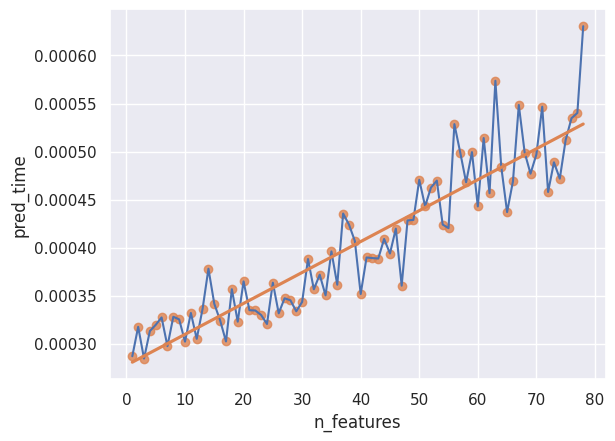

In [28]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['pred_time','n_features']].mean()
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='pred_time')
    sns.regplot(data=data, x="n_features", y="pred_time", ci=None)  # ci=None removes confidence intervals

print_plot()

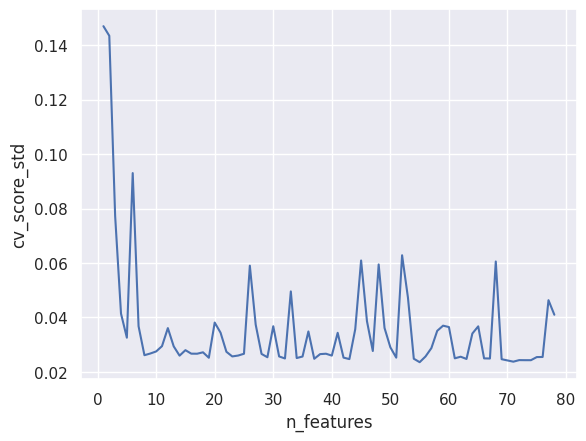

In [29]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['cv_score_std','n_features']].mean()
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='cv_score_std')

print_plot()

In [30]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time', 'detected']].mean().sort_values(['attack_recall', 'attack_precision'], ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time,detected
n_features,,,,,,,,
2,0.572318,0.750000,0.462700,0.815066,0.143439,8.894566,0.000318,0.75
4,0.640858,0.719808,0.588242,0.914475,0.041417,8.844436,0.000313,1.00
30,0.542841,0.621455,0.503077,0.943139,0.036781,9.000901,0.000344,0.75
5,0.461501,0.564578,0.425864,0.933018,0.032575,8.930002,0.000320,0.75
62,0.440837,0.561909,0.414478,0.949798,0.025584,9.245803,0.000457,0.75
...,...,...,...,...,...,...,...,...
39,0.000000,0.000000,0.000000,0.950054,0.026680,9.090746,0.000407,0.00
42,0.000000,0.000000,0.000000,0.950613,0.025255,9.171633,0.000389,0.00
46,0.000000,0.000000,0.000000,0.942491,0.038643,9.235113,0.000420,0.00


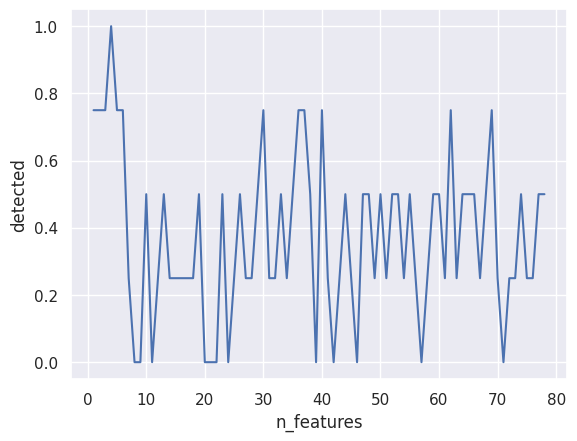

In [31]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['detected','n_features']].mean()
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='detected')

print_plot()

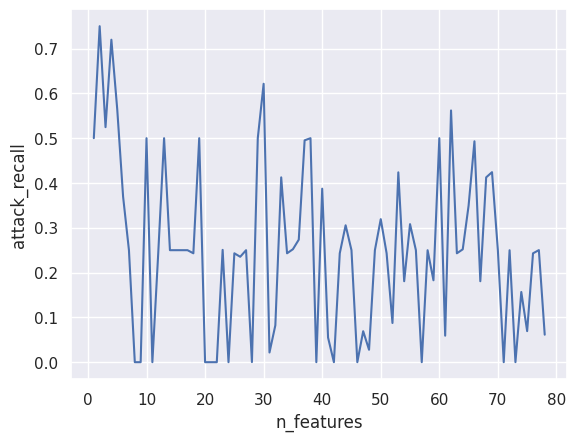

In [32]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_recall','n_features']].mean()
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_recall')

print_plot()

In [33]:
zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','attack_recall','attack_precision','cv_score_avg','cv_score_std','fit_time','pred_time']].mean().sort_values('attack_f1', ascending=False)

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,fit_time,pred_time
n_features,,,,,,,
4,0.640858,0.719808,0.588242,0.914475,0.041417,8.844436,0.000313
2,0.572318,0.750000,0.462700,0.815066,0.143439,8.894566,0.000318
30,0.542841,0.621455,0.503077,0.943139,0.036781,9.000901,0.000344
5,0.461501,0.564578,0.425864,0.933018,0.032575,8.930002,0.000320
3,0.450770,0.524626,0.440909,0.866731,0.077260,8.972624,0.000285
...,...,...,...,...,...,...,...
21,0.000000,0.000000,0.000000,0.945373,0.034408,9.095427,0.000335
22,0.000000,0.000000,0.000000,0.947966,0.027394,9.009940,0.000335
24,0.000000,0.000000,0.000000,0.949064,0.026012,9.016906,0.000321


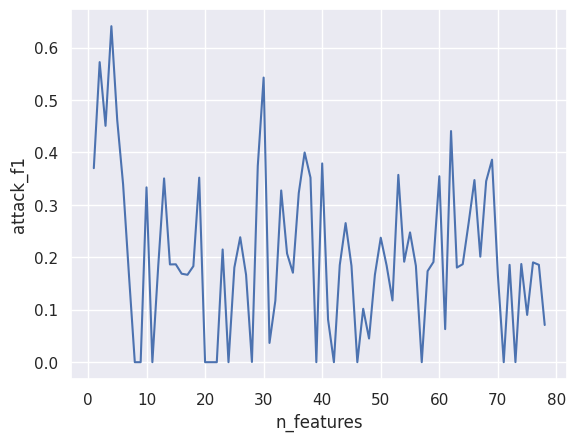

In [34]:
def print_plot():
    data = zero_day_feature_reduction_scores.groupby('n_features')[['attack_f1','n_features']].mean()
    sns.set_theme()
    sns.lineplot(data=data, x=data.index, y='attack_f1')

print_plot()

In [35]:
zero_day_feature_reduction_scores.query('n_features == 4')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
74,0.042159,0.027752,0.087669,0.918109,0.042121,4,XMRIGCC CryptoMiner,8.679739,0.000410,1
152,0.850584,1.000000,0.740014,0.944777,0.030252,4,Probing,8.829395,0.000281,1
230,0.799542,0.851479,0.753576,0.900985,0.043182,4,Bruteforce,8.794426,0.000276,1
308,0.871148,1.000000,0.771711,0.894031,0.050114,4,Bruteforce-XML,9.074182,0.000287,1


In [36]:
zero_day_feature_reduction_scores.query('n_features == 2')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
76,0.000000,0.0,0.000000,0.800339,0.272670,2,XMRIGCC CryptoMiner,9.010633,0.000267,0
154,0.763091,1.0,0.616933,0.804309,0.120461,2,Probing,8.934003,0.000339,1
232,0.763091,1.0,0.616933,0.826547,0.094319,2,Bruteforce,8.749371,0.000275,1
310,0.763091,1.0,0.616933,0.829070,0.086307,2,Bruteforce-XML,8.884255,0.000390,1


In [37]:
zero_day_feature_reduction_scores.query('n_features == 30')

,attack_f1,attack_recall,attack_precision,cv_score_avg,cv_score_std,n_features,attack_name,fit_time,pred_time,detected
48,0.727522,0.972248,0.581222,0.942809,0.029413,30,XMRIGCC CryptoMiner,9.047666,0.000361,1
126,0.584114,0.513571,0.677121,0.973551,0.013864,30,Probing,9.072479,0.000328,1
204,0.000000,0.000000,0.000000,0.939251,0.032820,30,Bruteforce,8.976752,0.000352,0
282,0.859727,1.000000,0.753966,0.916944,0.071025,30,Bruteforce-XML,8.906706,0.000332,1
